In [1]:
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from skbio import OrdinationResults
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (precision_recall_curve, auc,
                             accuracy_score, classification_report)
from statannotations.Annotator import Annotator
from biom import load_table
from matplotlib_venn import venn2

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Load data

In [2]:
#load rpca results
nPCs = 4
ord_18S = OrdinationResults.read('../results/joint-rpca/18S_ord_{}PCs.txt'.format(nPCs))
ord_mag = OrdinationResults.read('../results/joint-rpca/mag_ord_{}PCs.txt'.format(nPCs))
ord_gene = OrdinationResults.read('../results/joint-rpca/gene_ord_{}PCs.txt'.format(nPCs))
ord_gene_module = OrdinationResults.read('../results/joint-rpca/gene_module_ord_{}PCs.txt'.format(nPCs))
ord_metabolite = OrdinationResults.read('../results/joint-rpca/metabolite_ord_{}PCs.txt'.format(nPCs))
#load joint-rpca results
ord_joint = OrdinationResults.read('../results/joint-rpca/joint_ord_{}PCs.txt'.format(nPCs))
#load shared metadata
metadata = pd.read_csv('../network/split-matched-data/metadata_knn.tsv', index_col=0, sep='\t')

In [3]:
for ord, name in zip([ord_18S, ord_mag, ord_gene, ord_gene_module, ord_metabolite, ord_joint],
                     ['18S RPCA', 'MAG RPCA', 'Gene RPCA', 'Gene Module RPCA', 'Metabolite RPCA', 'Joint-RPCA']):
    print("{} with {} features".format(name, ord.features.shape[0]))
    print("Eigvals: ", ord.eigvals.values)
    print("Prop explained: ", ord.proportion_explained.values)
    print()

18S RPCA with 5431 features
Eigvals:  [93.09064035 54.63506677 43.74805468 41.32123107]
Prop explained:  [0.56742778 0.19545263 0.12531875 0.11180084]

MAG RPCA with 257 features
Eigvals:  [324.33673124  80.2481485   70.88832521  60.15480628]
Prop explained:  [0.87459435 0.05354075 0.04177956 0.03008535]

Gene RPCA with 2457 features
Eigvals:  [76.17102001 14.76430068  9.69162976  8.33676539]
Prop explained:  [0.93831685 0.03525297 0.0151902  0.01123997]

Gene Module RPCA with 377 features
Eigvals:  [173.74807179   5.22776893   4.62675072   3.5496359 ]
Prop explained:  [9.97972335e-01 9.03464893e-04 7.07669889e-04 4.16529851e-04]

Metabolite RPCA with 2333 features
Eigvals:  [101.66422711  14.32803815  13.92976621   8.68185405]
Prop explained:  [0.95608774 0.01899043 0.01794936 0.00697247]

Joint-RPCA with 10855 features
Eigvals:  [176.81114729 122.43351045 110.30745766  96.63676112]
Prop explained:  [0.46137623 0.22122619 0.17957492 0.13782267]



## Define functions

In [4]:
def rf_acc(ord_tables, ord_ids, shared_mt, cat_of_interest,
           ordination=True, n_folds=10, n_estimators=100, 
           random_state=42, optimize=False, param_grid=None, 
           metric='Accuracy', **kwargs):

    #initialize dataframe to store results
    if metric=='Accuracy':
        metrics_df = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                           'Report', 'Optimization'])
    elif metric=='APR':
        metrics_df = pd.DataFrame(columns=['Omic', 'Fold', 'Category', 'APR', 
                                           'Precision', 'Recall', 'Optimization'])

    acc_ord = {}
    
    #iterate over ordination tables
    for ord, omic in zip(ord_tables, ord_ids):
        
        if ordination:
            X = ord.samples.copy()
        else: 
            X = ord.copy()
        y = X.index.map(shared_mt[cat_of_interest])
        
        #iterate over folds
        acc_fold = {}
        for fold in ['traintest_{}'.format(i) for i in range(n_folds)]:
            
            #split data into pre-defined train and test sets
            X_group = X.index.map(shared_mt[fold])
            train_index = [True if x == 'train' else False for x in X_group]
            test_index = [True if x == 'test' else False for x in X_group]
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if optimize:
                print(f'Optimizing hyperparameters for {omic}, {fold}...')
                #initialize random forest
                rf = RandomForestClassifier(random_state=random_state)
                #hyperparameter optimization
                grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                                           cv=5, n_jobs=-1, verbose=0, scoring='accuracy')
                grid_search.fit(X_train.values, y_train)
                
                print(f'Best parameters found: {grid_search.best_params_}')
                print(f'Best cross-validation accuracy: {grid_search.best_score_}')

                #save best parameters
                best_params = grid_search.best_params_.copy()
                best_params['best_score'] = grid_search.best_score_

                #get best model
                best_rf = grid_search.best_estimator_

            else:
                #initialize random forest with user-defined parameters
                rf = RandomForestClassifier(n_estimators=n_estimators, 
                                            random_state=random_state, **kwargs)
                rf.fit(X_train.values, y_train)
                best_params = 'None'
                best_rf = rf
            
            #save classes or categories
            rf_classes = list(best_rf.classes_)

            if metric=='Accuracy':
                #predict on test set
                y_pred = best_rf.predict(X_test)
                #get accuracy and classification report
                accuracy = accuracy_score(y_test, y_pred)
                report = classification_report(y_test, y_pred)
                #save results for each fold
                acc_fold[fold] = (accuracy, report, best_params)

            elif metric=='APR':
                #predict probability scores on test set
                y_proba = best_rf.predict_proba(X_test)
                #binary apr
                apr_cat = {}
                for cat in y.unique():
                    cat_index = rf_classes.index(cat)
                    precision, recall, _ = precision_recall_curve(y_test, y_proba[:, cat_index],
                                                                  pos_label=cat)
                    apr = auc(x=recall, y=precision)
                    apr_cat[cat] = (apr, precision, recall, best_params)
                acc_fold[fold] = apr_cat
        
        #save results for each omic
        acc_ord[omic] = acc_fold

    #create df with metrics
    if metric=='Accuracy':
        for omic, acc_fold in acc_ord.items():
            for fold, metrics in acc_fold.items():
                metrics_df = metrics_df._append({'Omic': omic, 'Fold': fold, 
                                                 'Accuracy': metrics[0], 
                                                 'Report': metrics[1], 
                                                 'Optimization': metrics[2]}, 
                                                 ignore_index=True)
    elif metric=='APR':
        for omic, acc_fold in acc_ord.items():
            for fold, metrics in acc_fold.items():
                for cat, apr in metrics.items():
                    metrics_df = metrics_df._append({'Omic': omic, 'Fold': fold, 
                                                     'Category': cat, 'APR': apr[0],
                                                     'Precision': apr[1], 'Recall': apr[2],
                                                     'Optimization': apr[3]}, 
                                                     ignore_index=True)
    return metrics_df

## Ordination-based classification

### RF default params

In [5]:
#FACILITY
acc_ord_facility = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                      ord_gene_module, ord_metabolite, ord_joint],
                          ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                   "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                          shared_mt=metadata, cat_of_interest='facility', ordination=True, 
                          random_state=42, bootstrap=False, optimize=False, param_grid=None)

display(acc_ord_facility.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.851064,precision recall f1-score ...,None
1,18S_RPCA,traintest_1,0.787234,precision recall f1-score ...,None
2,18S_RPCA,traintest_2,0.765957,precision recall f1-score ...,None
3,18S_RPCA,traintest_3,0.861702,precision recall f1-score ...,None
4,18S_RPCA,traintest_4,0.787234,precision recall f1-score ...,None


In [5]:
#save results
#acc_ord_facility.to_csv('../results/joint-rpca/RF/rf_acc_facility_4PCs.csv', index=False)

In [6]:
#STAGE OF DECOPMPOSITION (ADD 0C)
acc_ord_stage = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                   ord_gene_module, ord_metabolite, ord_joint],
                        ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                 "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                        shared_mt=metadata, cat_of_interest='add_0c_group', ordination=True, 
                        random_state=42, bootstrap=False, optimize=False, param_grid=None)

display(acc_ord_stage.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.531915,precision recall f1-score ...,None
1,18S_RPCA,traintest_1,0.468085,precision recall f1-score ...,None
2,18S_RPCA,traintest_2,0.521277,precision recall f1-score ...,None
3,18S_RPCA,traintest_3,0.468085,precision recall f1-score ...,None
4,18S_RPCA,traintest_4,0.553191,precision recall f1-score ...,None


In [7]:
#save results
#acc_ord_stage.to_csv('../results/joint-rpca/RF/rf_acc_stage_4PCs.csv', index=False)

In [8]:
#SEASON
acc_ord_season = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                    ord_gene_module, ord_metabolite, ord_joint],
                        ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                 "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                        shared_mt=metadata, cat_of_interest='season', ordination=True, 
                        random_state=42, bootstrap=False, optimize=False, param_grid=None)

display(acc_ord_season.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.829787,precision recall f1-score ...,None
1,18S_RPCA,traintest_1,0.882979,precision recall f1-score ...,None
2,18S_RPCA,traintest_2,0.882979,precision recall f1-score ...,None
3,18S_RPCA,traintest_3,0.829787,precision recall f1-score ...,None
4,18S_RPCA,traintest_4,0.882979,precision recall f1-score ...,None


In [9]:
#save results
#acc_ord_season.to_csv('../results/joint-rpca/RF/rf_acc_season_4PCs.csv', index=False)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:7.474e-03 Stat=0.000e+00
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:3.342e-01 Stat=1.450e+01
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), 

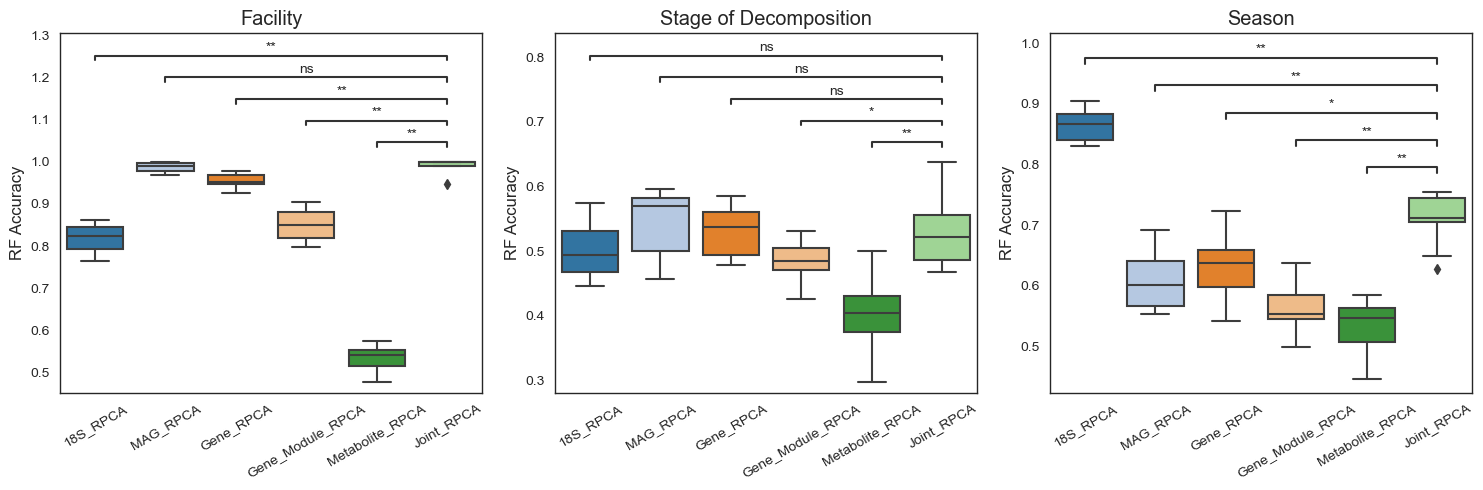

In [10]:
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]
plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order, 'palette':'tab20'}

fig, axn = plt.subplots(1, 3, figsize=(15, 5))
for ax_, data, title in zip(axn.flatten(), 
                           [acc_ord_facility, acc_ord_stage, acc_ord_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('RF Accuracy')
    ax_.set_title(title)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Binary APRs

In [8]:
#FACILITY
apr_ord_facility = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                      ord_gene_module, ord_metabolite, ord_joint],
                          ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                   "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                          shared_mt=metadata, cat_of_interest='facility', ordination=True, 
                          random_state=42, metric='APR')
display(apr_ord_facility.head())

,Omic,Fold,Category,APR,Precision,Recall,Optimization
0,18S_RPCA,traintest_0,STAFS,0.936702,"[0.32978723404255317, 0.41333333333333333, 0.4...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.967...",None
1,18S_RPCA,traintest_0,FIRS,0.915484,"[0.1595744680851064, 0.30612244897959184, 0.33...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.9333333333333333, ...",None
2,18S_RPCA,traintest_0,ARF,0.964445,"[0.5106382978723404, 0.5647058823529412, 0.6, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",None
3,18S_RPCA,traintest_1,STAFS,0.893285,"[0.32978723404255317, 0.41333333333333333, 0.4...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.967...",None
4,18S_RPCA,traintest_1,FIRS,0.796363,"[0.1595744680851064, 0.24528301886792453, 0.28...","[1.0, 0.8666666666666667, 0.8666666666666667, ...",None


In [46]:
#save results
#apr_ord_facility.to_csv('../results/joint-rpca/RF/rf_apr_facility_4PCs.csv', index=False)

In [11]:
#STAGE OF DECOPMPOSITION APR
apr_ord_stage = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                   ord_gene_module, ord_metabolite, ord_joint],
                        ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                 "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                        shared_mt=metadata, cat_of_interest='add_0c_group', ordination=True, 
                        random_state=42, metric='APR')
display(apr_ord_stage.head())

,Omic,Fold,Category,APR,Precision,Recall,Optimization
0,18S_RPCA,traintest_0,advanced,0.799006,"[0.46808510638297873, 0.4731182795698925, 0.48...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97727272...",None
1,18S_RPCA,traintest_0,active,0.532589,"[0.3723404255319149, 0.3804347826086957, 0.384...","[1.0, 1.0, 1.0, 1.0, 0.9714285714285714, 0.971...",None
2,18S_RPCA,traintest_0,early,0.140689,"[0.11702127659574468, 0.14285714285714285, 0.1...","[1.0, 1.0, 1.0, 1.0, 0.8181818181818182, 0.727...",None
3,18S_RPCA,traintest_0,initial,0.037479,"[0.0425531914893617, 0.046875, 0.04, 0.0476190...","[1.0, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0...",None
4,18S_RPCA,traintest_1,advanced,0.671534,"[0.3829787234042553, 0.391304347826087, 0.4, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97222222...",None


In [47]:
#save results
#apr_ord_stage.to_csv('../results/joint-rpca/RF/rf_apr_stage_4PCs.csv', index=False)

In [12]:
#SEASON
apr_ord_season = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                    ord_gene_module, ord_metabolite, ord_joint],
                        ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                 "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                        shared_mt=metadata, cat_of_interest='season', ordination=True, 
                        random_state=42, metric='APR')
display(apr_ord_season.head())

,Omic,Fold,Category,APR,Precision,Recall,Optimization
0,18S_RPCA,traintest_0,spring,0.986203,"[0.2978723404255319, 0.4666666666666667, 0.518...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",None
1,18S_RPCA,traintest_0,summer,0.902099,"[0.32978723404255317, 0.39473684210526316, 0.4...","[1.0, 0.967741935483871, 0.967741935483871, 0....",None
2,18S_RPCA,traintest_0,fall,0.856577,"[0.20212765957446807, 0.34545454545454546, 0.3...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",None
3,18S_RPCA,traintest_0,winter,0.931567,"[0.1702127659574468, 0.2962962962962963, 0.333...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",None
4,18S_RPCA,traintest_1,spring,0.957338,"[0.26595744680851063, 0.4166666666666667, 0.46...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 0.96, 0.96, 0....",None


In [48]:
#save results
#apr_ord_season.to_csv('../results/joint-rpca/RF/rf_apr_season_4PCs.csv', index=False)

In [49]:
#read results
acc_ord_facility = pd.read_csv('../results/joint-rpca/RF/rf_acc_facility_4PCs.csv')
apr_ord_stage = pd.read_csv('../results/joint-rpca/RF/rf_apr_stage_4PCs.csv')
apr_ord_season = pd.read_csv('../results/joint-rpca/RF/rf_apr_season_4PCs.csv')

Facility
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

STAFS_Metabolite_RPCA vs. STAFS_Joint_RPCA: Mann-Whitney-Wilcoxon test two-sided, P_val:8.745e-05 U_stat=0.000e+00
FIRS_Metabolite_RPCA vs. FIRS_Joint_RPCA: Mann-Whitney-Wilcoxon test two-sided, P_val:6.386e-05 U_stat=0.000e+00
ARF_Metabolite_RPCA vs. ARF_Joint_RPCA: Mann-Whitney-Wilcoxon test two-sided, P_val:8.745e-05 U_stat=0.000e+00
FIRS_Gene_Module_RPCA vs. FIRS_Joint_RPCA: Mann-Whitney-Wilcoxon test two-sided, P_val:2.297e-04 U_stat=5.000e+00
ARF_Gene_Module_RPCA vs. ARF_Joint_RPCA: Mann-Whitney-Wilcoxon test two-sided, P_val:8.745e-05 U_stat=0.000e+00
STAFS_Gene_Module_RPCA vs. STAFS_Joint_RPCA: Mann-Whitney-Wilcoxon test two-sided, P_val:8.745e-05 U_stat=0.000e+00
STAFS_Gene_RPCA vs. STAFS_Joint_RPCA: Mann-Whitney-Wilcoxon test two-sided, P_val:8.745e-05 U_stat=0.000e+00
FIRS_Gene

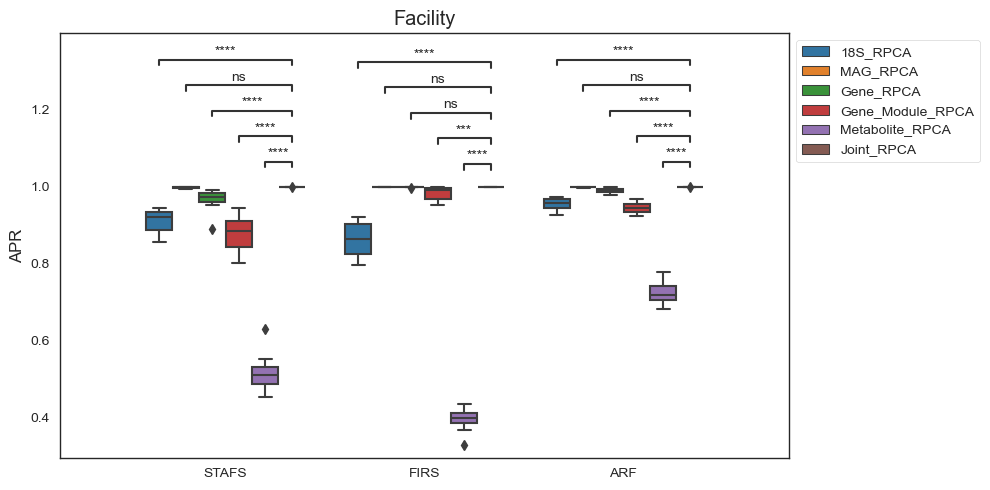

Stage of Decomposition
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

advanced_Metabolite_RPCA vs. advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
active_Metabolite_RPCA vs. active_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
early_Metabolite_RPCA vs. early_Joint_RPCA: Wilcoxon test (paired samples), P_val:5.859e-03 Stat=2.000e+00
initial_Metabolite_RPCA vs. initial_Joint_RPCA: Wilcoxon test (paired samples), P_val:8.398e-02 Stat=1.000e+01
active_Gene_Module_RPCA vs. active_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-02 Stat=5.000e+00
early_Gene_Module_RPCA vs. early_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.309e-01 Stat=1.200e+01
initial_Gene_Module_RPCA vs. initial_Joint_RPCA: Wilcoxon test (paired samples), P_val:5.566e-01 Stat=2.100e+01
advanced_Gene_M

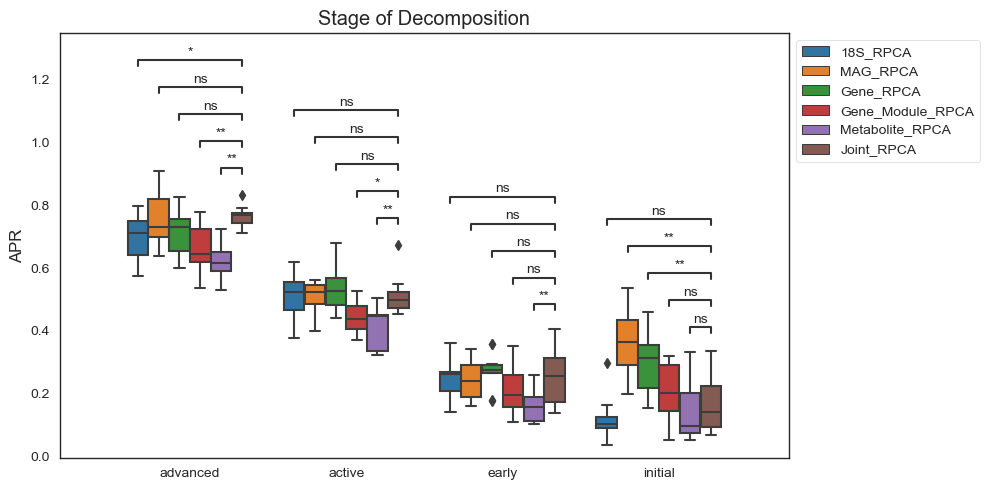

Season
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

spring_Metabolite_RPCA vs. spring_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
summer_Metabolite_RPCA vs. summer_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
fall_Metabolite_RPCA vs. fall_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
winter_Metabolite_RPCA vs. winter_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
summer_Gene_Module_RPCA vs. summer_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
fall_Gene_Module_RPCA vs. fall_Joint_RPCA: Wilcoxon test (paired samples), P_val:3.711e-02 Stat=7.000e+00
winter_Gene_Module_RPCA vs. winter_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
spring_Gene_Module_RPCA vs. spring_Joint_RP

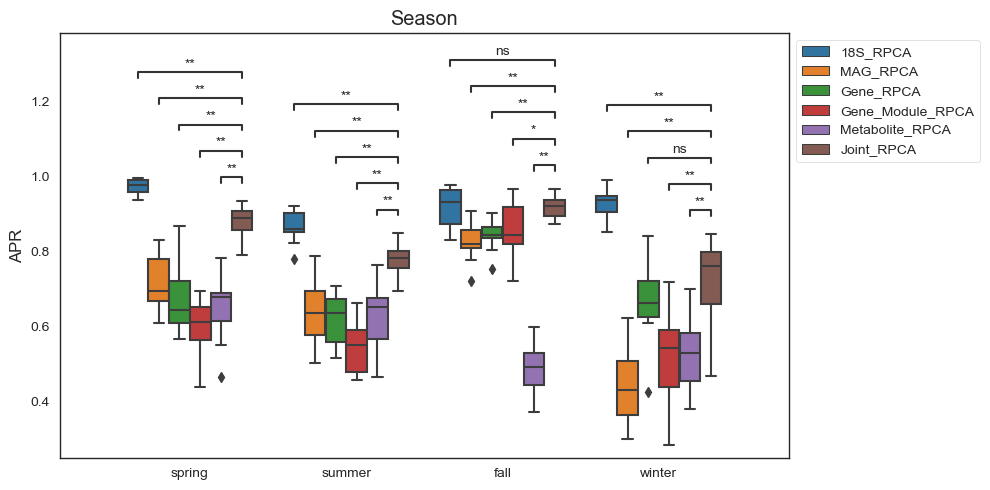

In [49]:
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
plotting_params = {'x':'Category', 'y':'APR', 
                   'palette':'tab10', 'hue':'Omic'}

#seaborn boxplot of individual APRs with stat test
for df, title in zip([apr_ord_facility, apr_ord_stage, apr_ord_season],
                     ['Facility', 'Stage of Decomposition', 'Season']):
    
    print(title)
    plotting_params['data'] = df
    groups = df['Category'].unique()
    stat_pairs = [[(group, rpca), (group, "Joint_RPCA")] for
                    group in groups for rpca in rpca_types]

    plt.figure(figsize=(10, 5))
    ax_ = plt.gca()
    sns.boxplot(ax=ax_, **plotting_params)

    #add statistical test
    if title=='Facility':
        test_name = "Mann-Whitney"
    else:
        test_name = "Wilcoxon"
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test=test_name).apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

    #x axis rotation
    #ax_.set_xticklabels(ax_.get_xticklabels(), rotation=45)
    ax_.set_xlabel('')
    ax_.set_ylabel('APR')
    ax_.set_title(title)
    #plot legend outside of box
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

advanced_Joint_RPCA vs. advanced_MAG_RPCA: Wilcoxon test (paired samples), P_val:8.457e-01 Stat=2.500e+01
advanced_Joint_RPCA vs. advanced_Gene_RPCA: Wilcoxon test (paired samples), P_val:8.398e-02 Stat=1.000e+01
advanced_Joint_RPCA vs. advanced_18S_RPCA: Wilcoxon test (paired samples), P_val:2.734e-02 Stat=6.000e+00
advanced_Joint_RPCA vs. advanced_Gene_Module_RPCA: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
advanced_Joint_RPCA vs. advanced_Metabolite_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00


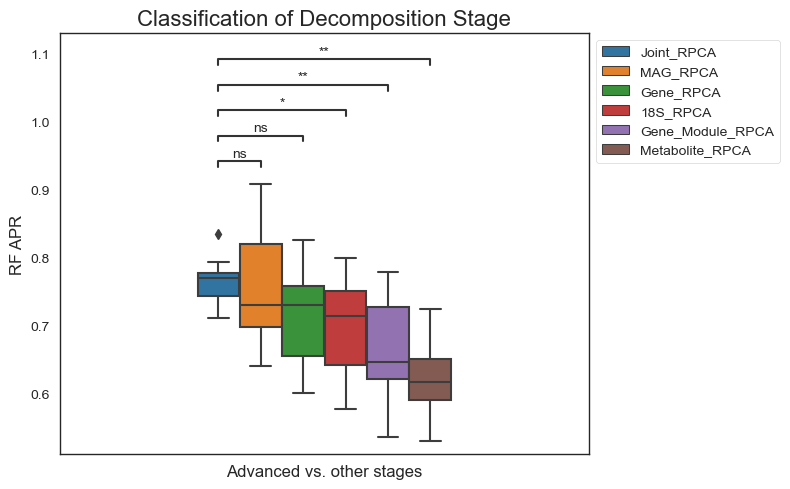

In [67]:
#focus on active vs all task
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
plotting_params = {'x':'Category', 'y':'APR', 
                   'palette':'tab10', 'hue':'Omic'}

#focus on active vs all task
df = apr_ord_stage[apr_ord_stage.Category=="advanced"]
#get order based on median APR
order = df.groupby('Omic')['APR'].median().sort_values(ascending=False).index

plotting_params['data'] = df
plotting_params['hue_order'] = order
groups = df['Category'].unique()
stat_pairs = [[(group, rpca), (group, "Joint_RPCA")] for
                group in groups for rpca in rpca_types]

plt.figure(figsize=(8, 5))
ax_ = plt.gca()
p = sns.boxplot(ax=ax_, **plotting_params)
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
ax_.set_xticklabels(['Advanced vs. other stages'], fontsize=12)
ax_.set_xlabel('')
ax_.set_ylabel('RF APR', fontsize=12)
ax_.set_title('Classification of Decomposition Stage', fontsize=16)
#plot legend outside of box
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [20]:
#calculate average AUC_APR for each fold
apr_avg_facility = pd.DataFrame(columns=['Omic', 'Fold', 'APR'])
apr_avg_stage = pd.DataFrame(columns=['Omic', 'Fold', 'APR'])
apr_avg_season = pd.DataFrame(columns=['Omic', 'Fold', 'APR'])

for fold_ in ['traintest_{}'.format(i) for i in range(10)]:
    avg1 = apr_ord_facility[apr_ord_facility['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_fac = pd.DataFrame(zip([fold_]*6, avg1.index, avg1['APR']),
                               columns=['Fold', 'Omic', 'APR'])
    apr_avg_facility = pd.concat([apr_avg_facility, apr_avg_fac])

    avg2 = apr_ord_stage[apr_ord_stage['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_st = pd.DataFrame(zip([fold_]*6, avg2.index, avg2['APR']),
                              columns=['Fold', 'Omic', 'APR'])
    apr_avg_stage = pd.concat([apr_avg_stage, apr_avg_st])

    avg3 = apr_ord_season[apr_ord_season['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_se = pd.DataFrame(zip([fold_]*6, avg3.index, avg3['APR']),
                              columns=['Fold', 'Omic', 'APR'])
    apr_avg_season = pd.concat([apr_avg_season, apr_avg_se])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.159e-01 Stat=3.000e+00
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), 

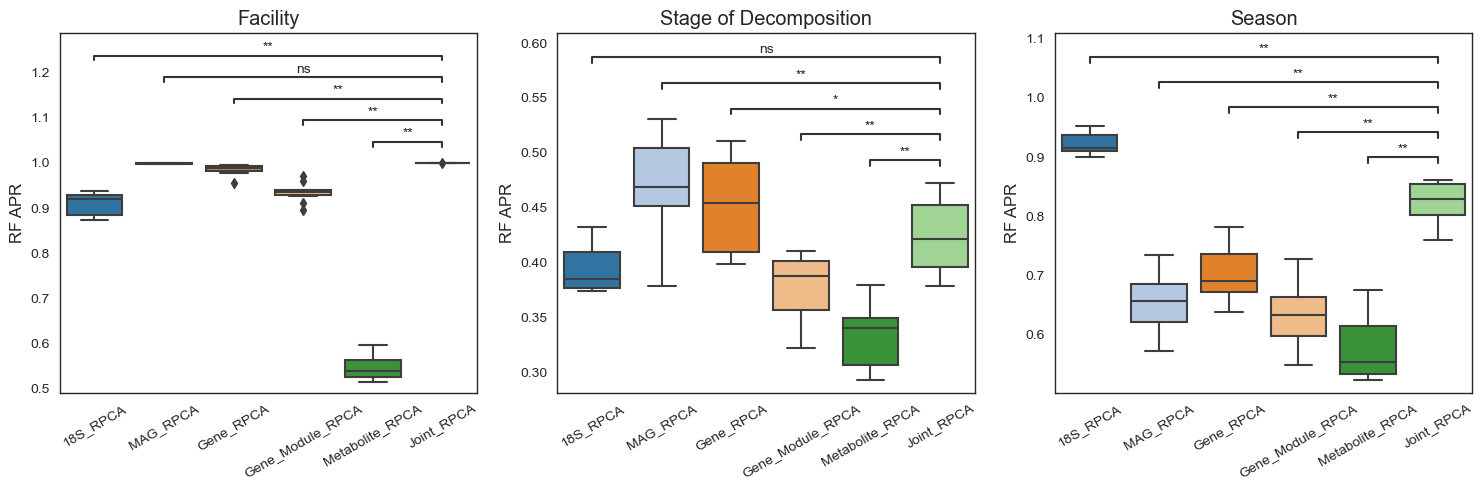

In [21]:
#seaborn boxplot with statistical test
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]
plotting_params = {'x':'Omic', 'y':'APR', 
                   'order':order, 'palette':'tab20'}

fig, axn = plt.subplots(1, 3, figsize=(15, 5))
for ax_, data, title in zip(axn.flatten(), 
                           [apr_avg_facility, apr_avg_stage, apr_avg_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('RF APR')
    ax_.set_title(title)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Binned stages of decomposition

In [22]:
#join early/initial together and active/advanced together
metadata_stage_binned = metadata.copy()
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'early', 'add_0c_group'] = 'early/initial'
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'initial', 'add_0c_group'] = 'early/initial'
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'active', 'add_0c_group'] = 'active/advanced'
metadata_stage_binned.loc[metadata_stage_binned['add_0c_group'] == 'advanced', 'add_0c_group'] = 'active/advanced'

In [23]:
#STAGE OF DECOMPOSITION (BINNED)
ord_stage_binned = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                      ord_gene_module, ord_metabolite, ord_joint],
                           ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",  
                                    "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"],
                           shared_mt=metadata_stage_binned, cat_of_interest='add_0c_group',
                           random_state=42, metric='APR')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

active/advanced_Metabolite_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
early/initial_Metabolite_RPCA vs. early/initial_Joint_RPCA: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
early/initial_Gene_Module_RPCA vs. early/initial_Joint_RPCA: Wilcoxon test (paired samples), P_val:9.219e-01 Stat=2.600e+01
active/advanced_Gene_Module_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.602e-01 Stat=1.300e+01
active/advanced_Gene_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
early/initial_Gene_RPCA vs. early/initial_Joint_RPCA: Wilcoxon test (paired samples), P_val:5.859e-03 Stat=2.000e+00
active/advanced_MAG_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon te

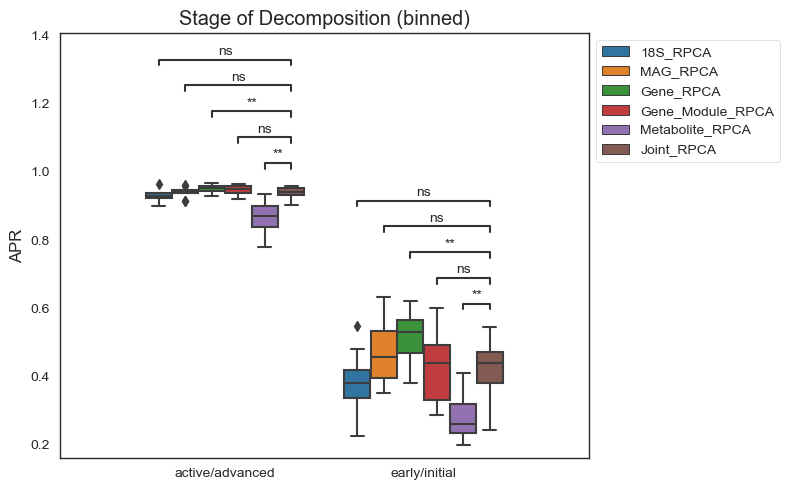

In [26]:
stages = ord_stage_binned.Category.unique()
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
stat_pairs = [[(stg, rpca), (stg, "Joint_RPCA")] for
                stg in stages for rpca in rpca_types]
plotting_params = {'x':'Category', 'y':'APR', 
                   'palette':'tab10', 'hue':'Omic',
                   'data':ord_stage_binned}

#seaborn boxplot of individual APRs with stat test
plt.figure(figsize=(8, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
#ax_.set_xticklabels(ax_.get_xticklabels(), rotation=45)
ax_.set_xlabel('')
ax_.set_ylabel('APR')
ax_.set_title('Stage of Decomposition (binned)')
#plot legend outside of box
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

active/advanced_Metabolite_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
active/advanced_Gene_Module_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.602e-01 Stat=1.300e+01
active/advanced_Gene_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
active/advanced_MAG_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.000e+00 Stat=2.700e+01
active/advanced_18S_RPCA vs. active/advanced_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.309e-01 Stat=1.200e+01


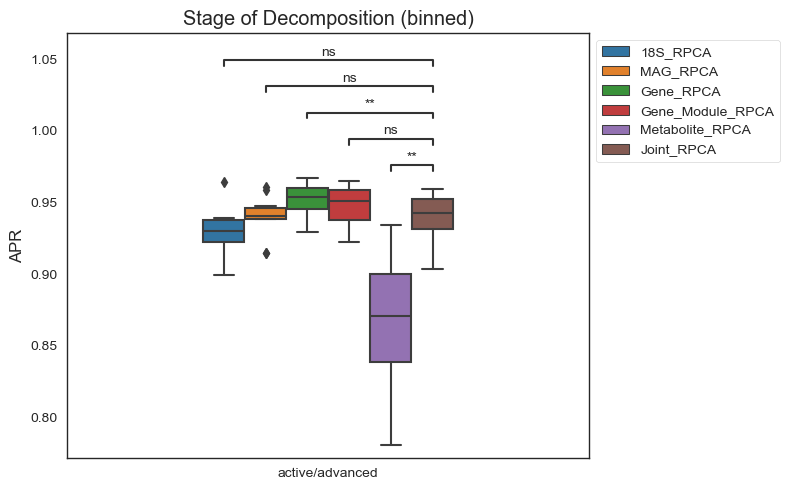

In [45]:
stages = ["active/advanced"]
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
stat_pairs = [[(stg, rpca), (stg, "Joint_RPCA")] for
                stg in stages for rpca in rpca_types]
plotting_params = {'x':'Category', 'y':'APR', 
                   'palette':'tab10', 'hue':'Omic',
                   'data':ord_stage_binned[ord_stage_binned.Category != 'early/initial']}

#seaborn boxplot of individual APRs with stat test
plt.figure(figsize=(8, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
#ax_.set_xticklabels(ax_.get_xticklabels(), rotation=45)
ax_.set_xlabel('')
ax_.set_ylabel('APR')
ax_.set_title('Stage of Decomposition (binned)')
#plot legend outside of box
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [27]:
#calculate average AUC_APR for each fold
apr_avg_stage_binned = pd.DataFrame(columns=['Fold', 'Omic', 'APR'])

for fold_ in ['traintest_{}'.format(i) for i in range(10)]:

    avg = ord_stage_binned[ord_stage_binned['Fold'] == fold_].groupby('Omic').mean(numeric_only=True)
    apr_avg_st = pd.DataFrame(zip([fold_]*6, avg.index, avg['APR']),
                              columns=['Fold', 'Omic', 'APR'])
    apr_avg_stage_binned = pd.concat([apr_avg_stage_binned, apr_avg_st])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.000e+00 Stat=2.700e+01
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:6.250e-01 Stat=2.200e+01
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.055e-01 Stat=1.100e+01


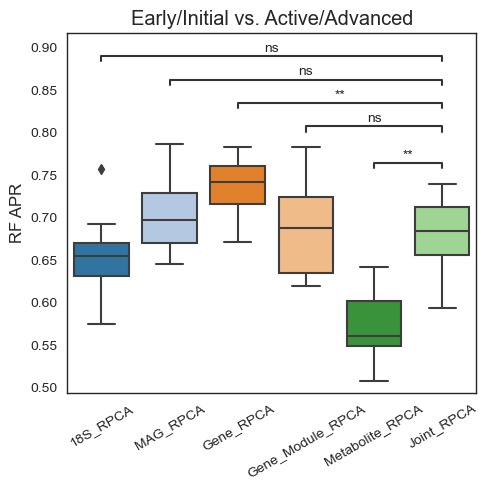

In [28]:
#seaborn boxplot with statistical test
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]

plotting_params = {'x':'Omic', 'y':'APR', 
                   'order':order, 'palette':'tab20',
                   'data':apr_avg_stage_binned}

fig = plt.figure(figsize=(5, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)
ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
ax_.set_xlabel('')
ax_.set_ylabel('RF APR')
ax_.set_title('Early/Initial vs. Active/Advanced')

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Hyper-parameter optimization

In [5]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [14]:
#FACILITY
acc_ord_facility_opt = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                          ord_gene_module, ord_metabolite, ord_joint],
                              ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                       "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                              shared_mt=metadata, cat_of_interest='facility', ordination=True, 
                              n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

Optimizing hyperparameters for 18S_RPCA, traintest_0...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.7964285714285715
Optimizing hyperparameters for 18S_RPCA, traintest_1...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.7857142857142858
Optimizing hyperparameters for 18S_RPCA, traintest_2...
Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8071428571428572
Optimizing hyperparameters for 18S_RPCA, traintest_3...
Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.7785714285714286
Optimizing hyperparameters for 18S_RPCA, traintest_4

In [15]:
#save results
#acc_ord_facility_opt.to_csv('../results/joint-rpca/rf_acc_facility_opt.csv', index=False)
display(acc_ord_facility_opt.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.787234,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
1,18S_RPCA,traintest_1,0.744681,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
2,18S_RPCA,traintest_2,0.670213,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': None, 'min_s..."
3,18S_RPCA,traintest_3,0.765957,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': 10, 'min_samp..."
4,18S_RPCA,traintest_4,0.797872,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."


In [18]:
#STAGE OF DECOMPOSITION (ADD 0C)
acc_ord_stage_opt = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                        ord_gene_module, ord_metabolite, ord_joint],
                            ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                     "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                            shared_mt=metadata, cat_of_interest='add_0c_group', ordination=True, 
                            n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

Optimizing hyperparameters for 18S_RPCA, traintest_0...
Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.46071428571428574
Optimizing hyperparameters for 18S_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.4821428571428572
Optimizing hyperparameters for 18S_RPCA, traintest_2...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.5178571428571429
Optimizing hyperparameters for 18S_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.5142857142857142
Optimizing hyperparameters for 18S_RPCA, traintest_4...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.45357142857142857
Optimizing hyperparameters for 18S_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5178571428571429
Optimizing hyperparameters for 18S_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.525
Optimizing hyperparameters for 18S_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.5142857142857143
Optimizing hyperparameters for 18S_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5142857142857142
Optimizing hyperparameters for 18S_RPCA, traintest_9...
Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.45357142857142857
Optimizing hyperparameters for MAG_RPCA, traintest_0...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5571428571428572
Optimizing hyperparameters for MAG_RPCA, traintest_1...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.5892857142857144
Optimizing hyperparameters for MAG_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5928571428571429
Optimizing hyperparameters for MAG_RPCA, traintest_3...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.6250000000000001
Optimizing hyperparameters for MAG_RPCA, traintest_4...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5535714285714286
Optimizing hyperparameters for MAG_RPCA, traintest_5...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5857142857142856
Optimizing hyperparameters for MAG_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation accuracy: 0.6214285714285714
Optimizing hyperparameters for MAG_RPCA, traintest_7...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5892857142857142
Optimizing hyperparameters for MAG_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6
Optimizing hyperparameters for MAG_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.6035714285714285
Optimizing hyperparameters for Gene_RPCA, traintest_0...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation accuracy: 0.5464285714285715
Optimizing hyperparameters for Gene_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5392857142857144
Optimizing hyperparameters for Gene_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5535714285714286
Optimizing hyperparameters for Gene_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5892857142857142
Optimizing hyperparameters for Gene_RPCA, traintest_4...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.5178571428571429
Optimizing hyperparameters for Gene_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5392857142857143
Optimizing hyperparameters for Gene_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5785714285714285
Optimizing hyperparameters for Gene_RPCA, traintest_7...
Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5714285714285714
Optimizing hyperparameters for Gene_RPCA, traintest_8...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5392857142857143
Optimizing hyperparameters for Gene_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5678571428571428
Optimizing hyperparameters for Gene_Module_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5428571428571428
Optimizing hyperparameters for Gene_Module_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.5178571428571429
Optimizing hyperparameters for Gene_Module_RPCA, traintest_2...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5535714285714286
Optimizing hyperparameters for Gene_Module_RPCA, traintest_3...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.55
Optimizing hyperparameters for Gene_Module_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.5535714285714286
Optimizing hyperparameters for Gene_Module_RPCA, traintest_5...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5607142857142857
Optimizing hyperparameters for Gene_Module_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5821428571428571
Optimizing hyperparameters for Gene_Module_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.55
Optimizing hyperparameters for Gene_Module_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5428571428571429
Optimizing hyperparameters for Gene_Module_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.5392857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_0...
Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4892857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.4821428571428571
Optimizing hyperparameters for Metabolite_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4821428571428571
Optimizing hyperparameters for Metabolite_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.46071428571428574
Optimizing hyperparameters for Metabolite_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.492857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation accuracy: 0.475
Optimizing hyperparameters for Metabolite_RPCA, traintest_6...
Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5250000000000001
Optimizing hyperparameters for Metabolite_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4928571428571429
Optimizing hyperparameters for Metabolite_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.49642857142857144
Optimizing hyperparameters for Metabolite_RPCA, traintest_9...
Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.4642857142857143
Optimizing hyperparameters for Joint_RPCA, traintest_0...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5785714285714285
Optimizing hyperparameters for Joint_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.5642857142857144
Optimizing hyperparameters for Joint_RPCA, traintest_2...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5714285714285715
Optimizing hyperparameters for Joint_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5964285714285713
Optimizing hyperparameters for Joint_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6035714285714286
Optimizing hyperparameters for Joint_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5642857142857143


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Optimizing hyperparameters for Joint_RPCA, traintest_6...
Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5571428571428572
Optimizing hyperparameters for Joint_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5892857142857142
Optimizing hyperparameters for Joint_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5928571428571429
Optimizing hyperparameters for Joint_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.6285714285714286


In [19]:
#save results
#acc_ord_stage_opt.to_csv('../results/joint-rpca/rf_acc_stage_opt.csv', index=False)
display(acc_ord_stage_opt.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.489362,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': 10, 'min_samp..."
1,18S_RPCA,traintest_1,0.446809,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': None, 'min_s..."
2,18S_RPCA,traintest_2,0.521277,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
3,18S_RPCA,traintest_3,0.446809,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': 10, 'min_samp..."
4,18S_RPCA,traintest_4,0.531915,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."


In [20]:
for fold in ['traintest_{}'.format(i) for i in range(10)]:
    for group in metadata.add_0c_group.unique():
        print(fold, group)
        print(metadata[metadata.add_0c_group == group][fold].value_counts())
    print()

traintest_0 early
train    36
test     11
Name: traintest_0, dtype: int64
traintest_0 advanced
train    118
test      44
Name: traintest_0, dtype: int64
traintest_0 initial
train    19
test      4
Name: traintest_0, dtype: int64
traintest_0 active
train    107
test      35
Name: traintest_0, dtype: int64

traintest_1 early
train    34
test     13
Name: traintest_1, dtype: int64
traintest_1 advanced
train    126
test      36
Name: traintest_1, dtype: int64
traintest_1 initial
train    17
test      6
Name: traintest_1, dtype: int64
traintest_1 active
train    103
test      39
Name: traintest_1, dtype: int64

traintest_2 early
train    36
test     11
Name: traintest_2, dtype: int64
traintest_2 advanced
train    125
test      37
Name: traintest_2, dtype: int64
traintest_2 initial
train    17
test      6
Name: traintest_2, dtype: int64
traintest_2 active
train    102
test      40
Name: traintest_2, dtype: int64

traintest_3 early
train    35
test     12
Name: traintest_3, dtype: int64
train

In [21]:
#SEASON
acc_ord_season_opt = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                        ord_gene_module, ord_metabolite, ord_joint],
                            ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                     "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                            shared_mt=metadata, cat_of_interest='season', ordination=True, 
                            n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

Optimizing hyperparameters for 18S_RPCA, traintest_0...
Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.8214285714285715
Optimizing hyperparameters for 18S_RPCA, traintest_1...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.7428571428571429
Optimizing hyperparameters for 18S_RPCA, traintest_2...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.7571428571428571
Optimizing hyperparameters for 18S_RPCA, traintest_3...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8357142857142857
Optimizing hyperparameters for 18S_RPCA, traintes

In [22]:
#save results
#acc_ord_season_opt.to_csv('../results/joint-rpca/rf_acc_season_opt.csv', index=False)
display(acc_ord_season_opt.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.819149,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': None, 'min_s..."
1,18S_RPCA,traintest_1,0.808511,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
2,18S_RPCA,traintest_2,0.765957,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
3,18S_RPCA,traintest_3,0.755319,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
4,18S_RPCA,traintest_4,0.851064,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': 10, 'min_samp..."


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:4.962e-01 Stat=5.000e+00
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), 

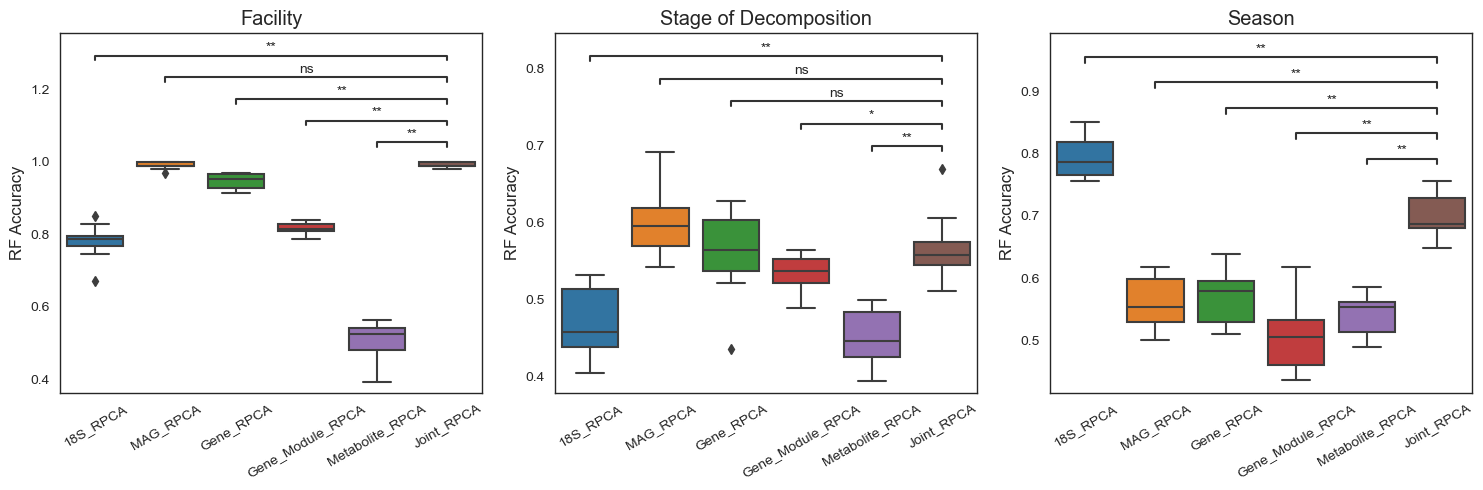

In [26]:
#plot results and run statistical test
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]
plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order, 'palette':'tab10'}

fig, axn = plt.subplots(1, 3, figsize=(15, 5))
for ax_, data, title in zip(axn.flatten(), 
                           [acc_ord_facility_opt, acc_ord_stage_opt, acc_ord_season_opt],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('RF Accuracy')
    ax_.set_title(title)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Bar plots with detailed groups

In [62]:
# load the results
acc_ord_season = pd.read_csv('../results/joint-rpca/RF/rf_acc_season_4PCS.csv')
#acc_ord_season = pd.read_csv('../results/joint-rpca/KNN/knn_acc_ord_season_4PCs.tsv', sep='\t', index_col=0)
# display(acc_ord_season_opt.head())
# print(acc_ord_season_opt.shape)

In [63]:
omic_f1_lst = []
groups = ['fall', 'spring', 'summer', 'winter']
for omic in acc_ord_season.Omic.unique():
    fold_f1_lst = []
    for fold in ['traintest_{}'.format(i) for i in range(10)]:
        #get report for each fold
        fold_report = acc_ord_season[(acc_ord_season.Omic == omic) & 
                                     (acc_ord_season.Fold == fold)].Report.values[0]
        #get each season's F1-score
        season_f1_lst = []
        for season, i in zip(groups, range(2, 6)):
            season_report = fold_report.split('\n')[i].split(' ')
            season_result = [x for x in season_report if len(x)>0][1:]
            season_f1 = [float(x) for x in season_result][2]
            season_f1_lst.append(season_f1)
        fold_f1_lst.extend(season_f1_lst)
    omic_f1_lst.extend(fold_f1_lst)

In [64]:
#create new dataframe with f1 results
n_omics = len(acc_ord_season.Omic.unique())
n_groups = len(groups)
omic_lst = [[omic] * 10 * n_groups for omic in acc_ord_season.Omic.unique()]
omic_lst = np.concatenate(omic_lst)
fold = [['traintest_{}'.format(i)] * n_groups for i in range(10)] * n_omics
fold = np.concatenate(fold)
season = ['fall', 'spring', 'summer', 'winter'] * acc_ord_season.shape[0]

f1_df = pd.DataFrame({'Omic': omic_lst, 'Fold': fold, 'Season': season, 'F1-score': omic_f1_lst})
f1_df.head()

,Omic,Fold,Season,F1-score
0,18S_RPCA,traintest_0,fall,0.81
1,18S_RPCA,traintest_0,spring,0.91
2,18S_RPCA,traintest_0,summer,0.75
3,18S_RPCA,traintest_0,winter,0.87
4,18S_RPCA,traintest_1,fall,0.94


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

fall_Metabolite_RPCA vs. fall_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
spring_Metabolite_RPCA vs. spring_Joint_RPCA: Wilcoxon test (paired samples), P_val:9.766e-03 Stat=3.000e+00
summer_Metabolite_RPCA vs. summer_Joint_RPCA: Wilcoxon test (paired samples), P_val:5.859e-03 Stat=2.500e+00
winter_Metabolite_RPCA vs. winter_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.079e-02 Stat=1.000e+00
spring_Gene_Module_RPCA vs. spring_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
summer_Gene_Module_RPCA vs. summer_Joint_RPCA: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
winter_Gene_Module_RPCA vs. winter_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
fall_Gene_Module_RPCA vs. fall_Joint_RPCA: Wil

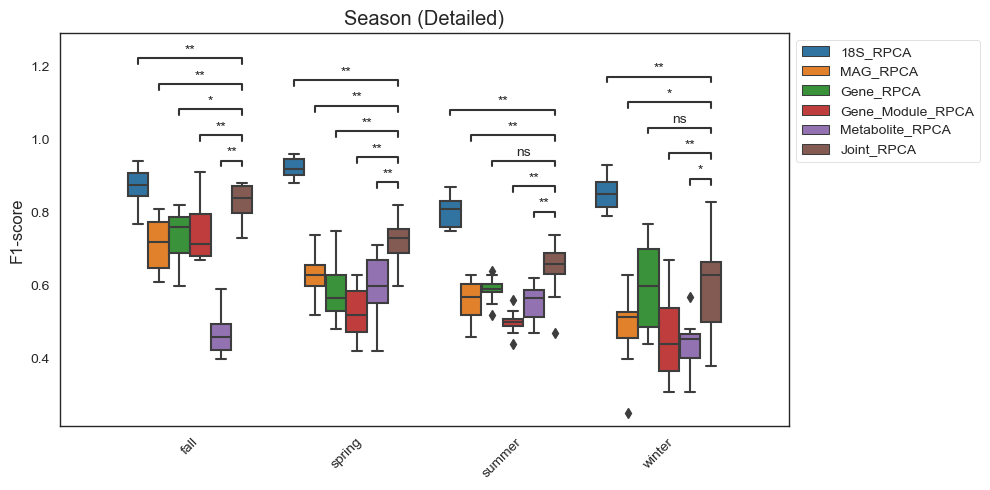

In [65]:
seasons = ["fall", "spring", "summer", "winter"]
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
stat_pairs = [[(season, rpca), (season, "Joint_RPCA")] for
               season in seasons for rpca in rpca_types]

plotting_params = {'x':'Season', 'y':'F1-score', 
                   'palette':'tab10',
                   'data':f1_df, 'hue':'Omic'}

#seaborn boxplot of individual AUC_APRs without stat test
plt.figure(figsize=(10, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
ax_.set_xticklabels(ax_.get_xticklabels(), rotation=45)
ax_.set_xlabel('')
ax_.set_ylabel('F1-score')
ax_.set_title('Season (Detailed)')
#plot legend outside of box
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


## Feature-based classification

In [5]:
def get_top_features(table, ordination, component='PC1', 
                     quantile=0.90, pseudocount=0):
    
    #get the loadings
    floadings = ordination.copy()
    floadings.rename(columns={0:"PC1", 1:"PC2", 
                              2:"PC3", 3:"PC4"}, inplace=True)
    table_df = table.copy().to_dataframe()
    top_pc_values = {}
    bottom_pc_values = {}
    beta_l = {}
    
    #sort loadings along each component
    floadings.sort_values(by=component, ascending=False, inplace=True)
    floadings_ = floadings[component].copy()
    #get top and bottom loading quantiles
    top_q = floadings_.quantile(quantile)
    bottom_q = floadings_.quantile(1-quantile)
    top_fts = floadings_[floadings_ >= top_q].index
    bottom_fts = floadings_[floadings_ <= bottom_q].index
    #aggregate the top and bottom features per sample
    num = table_df.loc[top_fts].sum(axis=0)
    num = num+pseudocount
    top_pc_values[component] = num
    denom = table_df.loc[bottom_fts].sum(axis=0)
    denom = denom+pseudocount
    bottom_pc_values[component] = denom
    #calculate trajectories
    beta_ = np.log(num) - np.log(denom)
    beta_l[component] = beta_

    #save top and bottom aggregated features as df
    top_fts_df = pd.DataFrame(top_pc_values, index=num.index)
    bottom_fts_df = pd.DataFrame(bottom_pc_values, index=denom.index)
    #save trajectories as df
    beta_df = pd.DataFrame(beta_l, index=num.index)
    #drop any NaN or infinity values
    beta_df = beta_df.sparse.to_dense()
    beta_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    beta_df.dropna(inplace=True)

    return (top_fts_df, bottom_fts_df, beta_df,
            top_fts.tolist(), bottom_fts.tolist())

In [6]:
# import the rest
all_tables = {'18S':'../network/split-matched-data/18S.biom',
              'mag':'../network/split-matched-data/mag.biom',
              'gene':'../network/split-matched-data/gene.biom',
              'gene_module':'../network/split-matched-data/gene_module.biom',
              'metabolite':'../network/split-matched-data/metabolite.biom'}

tables = {}
for tbl_id, tbl_path in all_tables.items():
    tables[tbl_id] = load_table(tbl_path)

In [7]:
#retrieve feature loadings from joint-rpca
joint_features = ord_joint.features

#for 18S, need to make sure features are in the original table
not_in_ord_18S = []
in_ord_18S = []

for id in tables['18S'].ids(axis='observation'):
    if id not in joint_features.index:
        not_in_ord_18S.append(id)
    else:
        in_ord_18S.append(id)
print("Not in ordination results: %i" % len(not_in_ord_18S))
print("In ordination results: %i" % len(in_ord_18S))

#keep only common features
tables['18S'] = tables['18S'].filter(ids_to_keep=in_ord_18S, axis='observation')

Not in ordination results: 42
In ordination results: 5431


### Default parameters

In [8]:
#common parameters
quantile = 0.90
pc_to_use = 'PC4'

In [9]:
#find top/bottom features from individual RPCA results
rpca_ord = {'18S': ord_18S, 'mag': ord_mag, 'gene': ord_gene, 
            'gene_module': ord_gene_module, 'metabolite': ord_metabolite}

rpca_top_fts = {}
rpca_bottom_fts = {}
rpca_traj = {}

for omic in tables.keys():
    ord_ = rpca_ord[omic].features.copy()
    table_ = tables[omic]
    top_fts, bottom_fts, beta_l, _, _ = get_top_features(table_, ord_, component=pc_to_use,
                                                         quantile=quantile, pseudocount=0)
    rpca_top_fts[omic] = top_fts
    rpca_bottom_fts[omic] = bottom_fts
    rpca_traj[omic] = beta_l

#find top/bottom features from joint-RPCA results
joint_rpca_top_fts = {}
joint_rpca_bottom_fts = {}
joint_rpca_traj = {}

for omic in tables.keys():
    
    table_ = tables[omic]
    if omic == '18S':
        ord_ = joint_features.loc[in_ord_18S]
    else:
        ord_ = joint_features.loc[table_.ids(axis='observation')]

    top_fts, bottom_fts, beta_l, _, _ = get_top_features(table_, ord_, component=pc_to_use,
                                                         quantile=quantile, pseudocount=0)
    joint_rpca_top_fts[omic] = top_fts
    joint_rpca_bottom_fts[omic] = bottom_fts
    joint_rpca_traj[omic] = beta_l

In [34]:
#FACILITY
acc_ratio_facility = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                        rpca_traj['gene_module'], rpca_traj['metabolite'],
                                        joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                        joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                            ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                     "Gene_Module_RPCA", "Metabolite_RPCA",
                                     "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                     "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                            shared_mt=metadata, cat_of_interest='facility', ordination=False, 
                            n_folds=10, random_state=42, optimize=False, param_grid=None)

In [10]:
#save results
#acc_ratio_facility.to_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_facility_4PCs.csv'.format(pc_to_use), index=False)

#read results
acc_ratio_facility = pd.read_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_facility_4PCs.csv'.format(pc_to_use))
display(acc_ratio_facility.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.517647,precision recall f1-score ...,NaN
1,18S_RPCA,traintest_1,0.546512,precision recall f1-score ...,NaN
2,18S_RPCA,traintest_2,0.532468,precision recall f1-score ...,NaN
3,18S_RPCA,traintest_3,0.642857,precision recall f1-score ...,NaN
4,18S_RPCA,traintest_4,0.580247,precision recall f1-score ...,NaN


In [14]:
#STAGE OF DECOMPOSITION
acc_ratio_stage = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                     rpca_traj['gene_module'], rpca_traj['metabolite'],
                                     joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                     joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                         ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                  "Gene_Module_RPCA", "Metabolite_RPCA",
                                  "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                  "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                         shared_mt=metadata, cat_of_interest='add_0c_group', ordination=False, 
                         n_folds=10, random_state=42, optimize=False, param_grid=None)

In [13]:
#save results
#acc_ratio_stage.to_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_stage_4PCs.csv'.format(pc_to_use), index=False)
#read results
acc_ratio_stage = pd.read_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_stage_4PCs.csv'.format(pc_to_use))
display(acc_ratio_stage.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.329412,precision recall f1-score ...,NaN
1,18S_RPCA,traintest_1,0.348837,precision recall f1-score ...,NaN
2,18S_RPCA,traintest_2,0.298701,precision recall f1-score ...,NaN
3,18S_RPCA,traintest_3,0.333333,precision recall f1-score ...,NaN
4,18S_RPCA,traintest_4,0.296296,precision recall f1-score ...,NaN


In [16]:
#SEASON
acc_ratio_season = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                      rpca_traj['gene_module'], rpca_traj['metabolite'],
                                      joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                      joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                          ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                   "Gene_Module_RPCA", "Metabolite_RPCA",
                                   "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                   "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                          shared_mt=metadata, cat_of_interest='season', ordination=False, 
                          n_folds=10, random_state=42, optimize=False, param_grid=None)

In [14]:
#save results
#acc_ratio_season.to_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_season_4PCs.csv'.format(pc_to_use), index=False)
#read results
acc_ratio_season = pd.read_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_season_4PCs.csv'.format(pc_to_use))
display(acc_ratio_season.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.282353,precision recall f1-score ...,NaN
1,18S_RPCA,traintest_1,0.267442,precision recall f1-score ...,NaN
2,18S_RPCA,traintest_2,0.272727,precision recall f1-score ...,NaN
3,18S_RPCA,traintest_3,0.261905,precision recall f1-score ...,NaN
4,18S_RPCA,traintest_4,0.333333,precision recall f1-score ...,NaN


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.386e-01 Stat=1.000e+01
MAG_RPCA vs. MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Gene_Joint-RPCA: Wilcoxon test (paired samples), P_val:7.530e-02 Stat=7.500e+00
Gene_Module_RPCA vs. Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:3.711e-02 Stat=7.000e+00
Metabolite_RPCA vs. Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:6.445e-02 Stat=9.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. MAG_Joint-RPCA: Wil

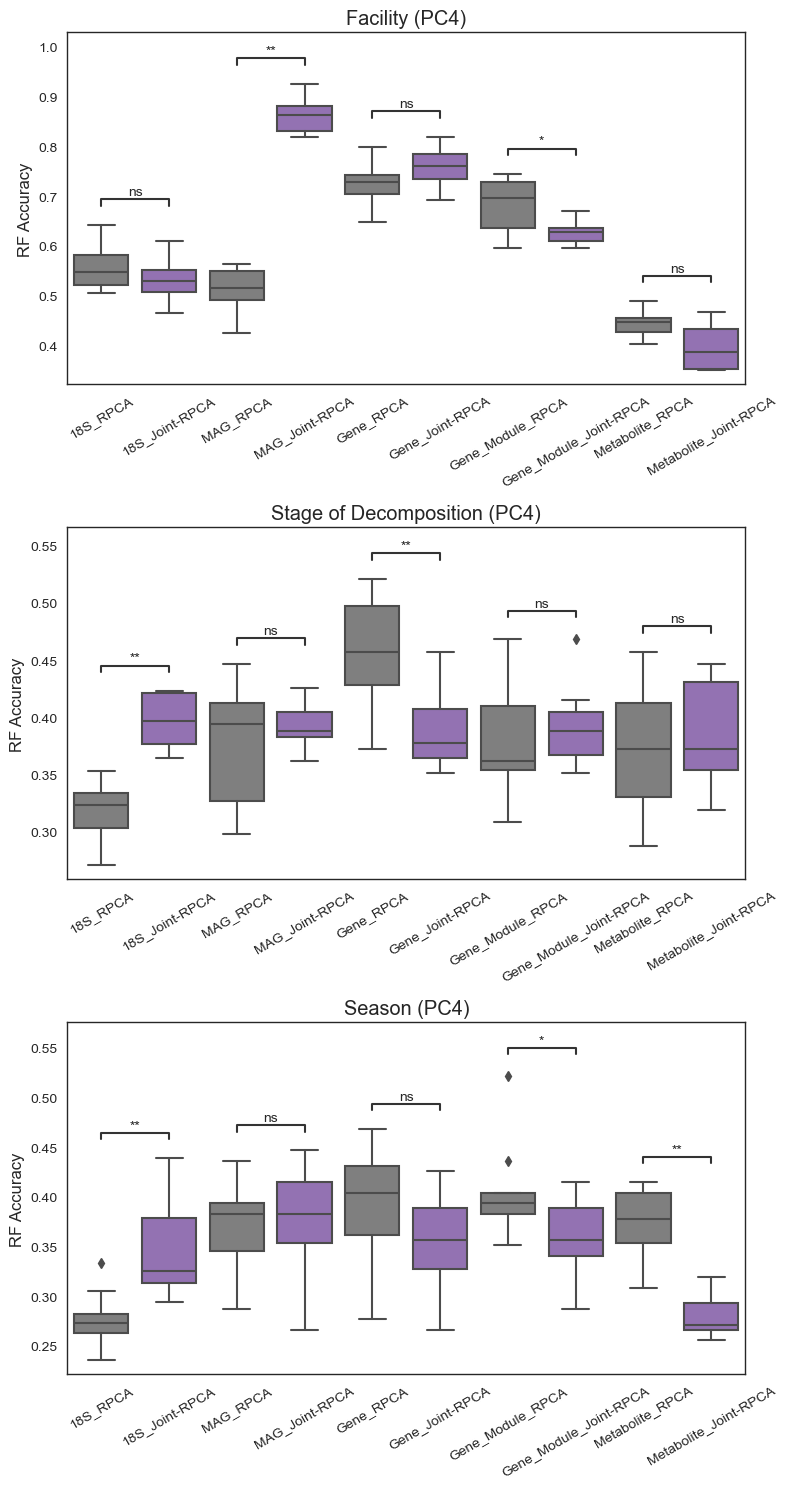

In [18]:
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']

stat_pairs = [('18S_RPCA', '18S_Joint-RPCA'), 
              ('MAG_RPCA', 'MAG_Joint-RPCA'),
              ('Gene_RPCA', 'Gene_Joint-RPCA'), 
              ('Gene_Module_RPCA', 'Gene_Module_Joint-RPCA'),
              ('Metabolite_RPCA', 'Metabolite_Joint-RPCA')]

pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}

plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order_v1, 'palette':pair_palette}

fig, axn = plt.subplots(3, 1, figsize=(8, 15))

for ax_, data, title in zip(axn.flatten(), 
                           [acc_ratio_facility, acc_ratio_stage, acc_ratio_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('RF Accuracy')
    ax_.set_title('{} ({})'.format(title, pc_to_use))

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Hyper-parameter optimization

In [ ]:
#common parameters
quantile = 0.90
pc_to_use = 'PC3'

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
#find top/bottom features from individual RPCA results
rpca_ord = {'18S': ord_18S, 'mag': ord_mag, 'gene': ord_gene, 
            'gene_module': ord_gene_module, 'metabolite': ord_metabolite}

rpca_top_fts = {}
rpca_bottom_fts = {}
rpca_traj = {}

for omic in tables.keys():
    ord_ = rpca_ord[omic].features.copy()
    table_ = tables[omic]
    top_fts, bottom_fts, beta_l, _, _ = get_top_features(table_, ord_, component=pc_to_use,
                                                         quantile=quantile, pseudocount=0)
    rpca_top_fts[omic] = top_fts
    rpca_bottom_fts[omic] = bottom_fts
    rpca_traj[omic] = beta_l

#find top/bottom features from joint-RPCA results
joint_rpca_top_fts = {}
joint_rpca_bottom_fts = {}
joint_rpca_traj = {}

for omic in tables.keys():
    
    table_ = tables[omic]
    if omic == '18S':
        ord_ = joint_features.loc[in_ord_18S]
    else:
        ord_ = joint_features.loc[table_.ids(axis='observation')]

    top_fts, bottom_fts, beta_l, _, _ = get_top_features(table_, ord_, component=pc_to_use,
                                                         quantile=quantile, pseudocount=0)
    joint_rpca_top_fts[omic] = top_fts
    joint_rpca_bottom_fts[omic] = bottom_fts
    joint_rpca_traj[omic] = beta_l

In [ ]:
#FACILITY
acc_ratio_facility_opt = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                            rpca_traj['gene_module'], rpca_traj['metabolite'],
                                            joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                            joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                                ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                         "Gene_Module_RPCA", "Metabolite_RPCA",
                                         "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                         "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                                shared_mt=metadata, cat_of_interest='facility', ordination=False, 
                                n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

Optimizing hyperparameters for 18S_RPCA, traintest_0...


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6087585034013606
Optimizing hyperparameters for 18S_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6193262411347519
Optimizing hyperparameters for 18S_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.6264489795918367
Optimizing hyperparameters for 18S_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.6177721088435375
Optimizing hyperparameters for 18S_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6065476190476191
Optimizing hyperparameters for 18S_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6251700680272109
Optimizing hyperparameters for 18S_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5638605442176872
Optimizing hyperparameters for 18S_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.6
Optimizing hyperparameters for 18S_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5819727891156463
Optimizing hyperparameters for 18S_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5870748299319727
Optimizing hyperparameters for MAG_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5964285714285714
Optimizing hyperparameters for MAG_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.6071428571428571
Optimizing hyperparameters for MAG_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5642857142857143
Optimizing hyperparameters for MAG_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.625
Optimizing hyperparameters for MAG_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6464285714285715
Optimizing hyperparameters for MAG_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6285714285714286
Optimizing hyperparameters for MAG_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6178571428571429
Optimizing hyperparameters for MAG_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5928571428571429
Optimizing hyperparameters for MAG_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6321428571428571
Optimizing hyperparameters for MAG_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.6214285714285714
Optimizing hyperparameters for Gene_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.7821428571428573
Optimizing hyperparameters for Gene_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.7892857142857143
Optimizing hyperparameters for Gene_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.7642857142857142
Optimizing hyperparameters for Gene_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.7642857142857143
Optimizing hyperparameters for Gene_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.7892857142857143
Optimizing hyperparameters for Gene_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.7535714285714287
Optimizing hyperparameters for Gene_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.7714285714285714
Optimizing hyperparameters for Gene_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.7785714285714286
Optimizing hyperparameters for Gene_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.7857142857142857
Optimizing hyperparameters for Gene_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.7678571428571428
Optimizing hyperparameters for Gene_Module_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5964285714285714
Optimizing hyperparameters for Gene_Module_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6035714285714285
Optimizing hyperparameters for Gene_Module_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6214285714285714
Optimizing hyperparameters for Gene_Module_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5892857142857142
Optimizing hyperparameters for Gene_Module_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6142857142857142
Optimizing hyperparameters for Gene_Module_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5607142857142857
Optimizing hyperparameters for Gene_Module_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5892857142857143
Optimizing hyperparameters for Gene_Module_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.6071428571428571
Optimizing hyperparameters for Gene_Module_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6321428571428571
Optimizing hyperparameters for Gene_Module_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.6107142857142858
Optimizing hyperparameters for Metabolite_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4892857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.46071428571428574
Optimizing hyperparameters for Metabolite_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.49642857142857155
Optimizing hyperparameters for Metabolite_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4642857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4714285714285714
Optimizing hyperparameters for Metabolite_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.45714285714285713
Optimizing hyperparameters for Metabolite_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4928571428571429
Optimizing hyperparameters for Metabolite_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5071428571428572
Optimizing hyperparameters for Metabolite_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.46785714285714286
Optimizing hyperparameters for Metabolite_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.4892857142857142
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.6916666666666667
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6289965986394558
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6791836734693877
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.6427721088435374
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6326530612244897
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6869897959183674
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6704489795918367
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.6389455782312925
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.653061224489796
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6304421768707483
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.8321428571428571
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.8214285714285714
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8428571428571429
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8321428571428571
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.8321428571428571
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.8357142857142856
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.875
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.8428571428571429
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.8
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.7892857142857143
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.8821428571428571
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.875
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8857142857142858
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8928571428571429
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.8964285714285714
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.8857142857142858
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8892857142857142
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8607142857142858
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.8678571428571429
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.875
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.8892857142857142
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.8571428571428571
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8571428571428571
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8607142857142858
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8571428571428571
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8785714285714287
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8892857142857142
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8607142857142858
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.8964285714285716
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.8785714285714287
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.475
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4821428571428571
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.47142857142857153
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.48571428571428577
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42142857142857143
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.46785714285714286
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.48571428571428565
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4821428571428571
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.47857142857142854


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
#save results
acc_ratio_facility_opt.to_csv('../results/joint-rpca/rf_acc_{}-ratio_facility_opt.csv'.format(pc_to_use), index=False)

#read results
#acc_ratio_facility_opt = pd.read_csv('../results/joint-rpca/rf_acc_{}-ratio_facility_opt.csv'.format(pc_to_use))
display(acc_ratio_facility_opt.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.590361,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': 10, 'min_sam..."
1,18S_RPCA,traintest_1,0.655172,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': 10, 'min_sam..."
2,18S_RPCA,traintest_2,0.571429,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
3,18S_RPCA,traintest_3,0.564706,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': None, 'min_s..."
4,18S_RPCA,traintest_4,0.646341,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': 10, 'min_sam..."


In [ ]:
#STAGE OF DECOMPOSITION
acc_ratio_stage_opt = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                         rpca_traj['gene_module'], rpca_traj['metabolite'],
                                         joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                         joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                             ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                      "Gene_Module_RPCA", "Metabolite_RPCA",
                                      "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                      "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                             shared_mt=metadata, cat_of_interest='add_0c_group', ordination=False, 
                             n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

Optimizing hyperparameters for 18S_RPCA, traintest_0...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4283163265306122
Optimizing hyperparameters for 18S_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.47313829787234046
Optimizing hyperparameters for 18S_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.43387755102040815
Optimizing hyperparameters for 18S_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.43571428571428567
Optimizing hyperparameters for 18S_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.397874149659864
Optimizing hyperparameters for 18S_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.4737244897959184
Optimizing hyperparameters for 18S_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.46071428571428574
Optimizing hyperparameters for 18S_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4291666666666667
Optimizing hyperparameters for 18S_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.434608843537415
Optimizing hyperparameters for 18S_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.40926870748299315
Optimizing hyperparameters for MAG_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.4357142857142858
Optimizing hyperparameters for MAG_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4892857142857142
Optimizing hyperparameters for MAG_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.5214285714285715
Optimizing hyperparameters for MAG_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.5285714285714287
Optimizing hyperparameters for MAG_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.48571428571428565
Optimizing hyperparameters for MAG_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5392857142857143
Optimizing hyperparameters for MAG_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.49642857142857144
Optimizing hyperparameters for MAG_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5
Optimizing hyperparameters for MAG_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.5107142857142858
Optimizing hyperparameters for MAG_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5178571428571429
Optimizing hyperparameters for Gene_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42142857142857143
Optimizing hyperparameters for Gene_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for Gene_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4821428571428571
Optimizing hyperparameters for Gene_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.4607142857142857
Optimizing hyperparameters for Gene_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.43571428571428567
Optimizing hyperparameters for Gene_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5035714285714287
Optimizing hyperparameters for Gene_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.43928571428571433
Optimizing hyperparameters for Gene_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.49642857142857144
Optimizing hyperparameters for Gene_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4428571428571429
Optimizing hyperparameters for Gene_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.42857142857142855
Optimizing hyperparameters for Gene_Module_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4571428571428572
Optimizing hyperparameters for Gene_Module_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4714285714285714
Optimizing hyperparameters for Gene_Module_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4107142857142857
Optimizing hyperparameters for Gene_Module_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.45357142857142857
Optimizing hyperparameters for Gene_Module_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42142857142857143
Optimizing hyperparameters for Gene_Module_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5142857142857142
Optimizing hyperparameters for Gene_Module_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for Gene_Module_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.46428571428571425
Optimizing hyperparameters for Gene_Module_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for Gene_Module_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4392857142857142
Optimizing hyperparameters for Metabolite_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.46785714285714286
Optimizing hyperparameters for Metabolite_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42142857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4071428571428572
Optimizing hyperparameters for Metabolite_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4607142857142857
Optimizing hyperparameters for Metabolite_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.475
Optimizing hyperparameters for Metabolite_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4107142857142857
Optimizing hyperparameters for Metabolite_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4142857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4
Optimizing hyperparameters for Metabolite_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4142857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3916666666666667
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4712585034013606
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.46636734693877546
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.4351190476190476
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42857142857142855
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5166666666666667
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4879183673469387
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.4649659863945578
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.47346938775510206
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42023809523809524
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4178571428571428
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.44642857142857145
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.42142857142857154
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.45714285714285713
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.41785714285714287
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.4535714285714286
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.4892857142857143
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.43571428571428567
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4428571428571429
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.425
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4428571428571429
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.4821428571428572
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.46785714285714286
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4107142857142857
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.4
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.41785714285714287
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4214285714285714
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4392857142857142
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.44642857142857145
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.48571428571428577
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.46071428571428574
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4107142857142857
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4821428571428571
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.4392857142857142
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4607142857142857
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.41071428571428575
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.4607142857142857
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.44642857142857145
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.42142857142857143
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4000000000000001
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3857142857142858
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.42857142857142866
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42142857142857143
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.475
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42857142857142855
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.43571428571428567
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.44642857142857134


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

In [ ]:
#save results
acc_ratio_stage_opt.to_csv('../results/joint-rpca/rf_acc_{}-ratio_stage_opt.csv'.format(pc_to_use), index=False)
#read results
#acc_ratio_stage_opt = pd.read_csv('../results/joint-rpca/rf_acc_{}-ratio_stage_opt.csv'.format(pc_to_use))
display(acc_ratio_stage_opt.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.421687,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
1,18S_RPCA,traintest_1,0.402299,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': 10, 'min_samp..."
2,18S_RPCA,traintest_2,0.441558,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
3,18S_RPCA,traintest_3,0.352941,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': None, 'min_s..."
4,18S_RPCA,traintest_4,0.463415,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': 10, 'min_sam..."


In [ ]:
#SEASON
acc_ratio_season_opt = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                          rpca_traj['gene_module'], rpca_traj['metabolite'],
                                          joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                          joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                              ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                       "Gene_Module_RPCA", "Metabolite_RPCA",
                                       "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                       "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                              shared_mt=metadata, cat_of_interest='season', ordination=False, 
                              n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

Optimizing hyperparameters for 18S_RPCA, traintest_0...
Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3539965986394558
Optimizing hyperparameters for 18S_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4181737588652482
Optimizing hyperparameters for 18S_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.3533877551020408
Optimizing hyperparameters for 18S_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.35688775510204085
Optimizing hyperparameters for 18S_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.3852891156462585
Optimizing hyperparameters for 18S_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.3697278911564626
Optimizing hyperparameters for 18S_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.3447278911564625
Optimizing hyperparameters for 18S_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.3916666666666667
Optimizing hyperparameters for 18S_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.34829931972789113
Optimizing hyperparameters for 18S_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.33877551020408164
Optimizing hyperparameters for MAG_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.4035714285714286
Optimizing hyperparameters for MAG_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3821428571428571
Optimizing hyperparameters for MAG_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4178571428571428
Optimizing hyperparameters for MAG_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.41428571428571426
Optimizing hyperparameters for MAG_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3928571428571429
Optimizing hyperparameters for MAG_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.38571428571428573
Optimizing hyperparameters for MAG_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.36428571428571427
Optimizing hyperparameters for MAG_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3785714285714286
Optimizing hyperparameters for MAG_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.33571428571428574
Optimizing hyperparameters for MAG_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.37857142857142856
Optimizing hyperparameters for Gene_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3107142857142857
Optimizing hyperparameters for Gene_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.32142857142857145
Optimizing hyperparameters for Gene_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.325
Optimizing hyperparameters for Gene_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3142857142857142
Optimizing hyperparameters for Gene_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.29642857142857143
Optimizing hyperparameters for Gene_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.25357142857142856
Optimizing hyperparameters for Gene_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.32857142857142857
Optimizing hyperparameters for Gene_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.2785714285714286
Optimizing hyperparameters for Gene_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.26785714285714285
Optimizing hyperparameters for Gene_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.30357142857142855
Optimizing hyperparameters for Gene_Module_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.28214285714285714
Optimizing hyperparameters for Gene_Module_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.325
Optimizing hyperparameters for Gene_Module_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.2857142857142857
Optimizing hyperparameters for Gene_Module_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.2857142857142857
Optimizing hyperparameters for Gene_Module_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.29285714285714287
Optimizing hyperparameters for Gene_Module_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3357142857142857
Optimizing hyperparameters for Gene_Module_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3142857142857143
Optimizing hyperparameters for Gene_Module_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.33214285714285713
Optimizing hyperparameters for Gene_Module_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3178571428571428
Optimizing hyperparameters for Gene_Module_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.30714285714285716
Optimizing hyperparameters for Metabolite_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.425
Optimizing hyperparameters for Metabolite_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42857142857142855
Optimizing hyperparameters for Metabolite_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.41785714285714287
Optimizing hyperparameters for Metabolite_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for Metabolite_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4178571428571428
Optimizing hyperparameters for Metabolite_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.42142857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.475
Optimizing hyperparameters for Metabolite_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.46785714285714286
Optimizing hyperparameters for Metabolite_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4035714285714286
Optimizing hyperparameters for Metabolite_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.47857142857142865
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.3458333333333333
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.35085034013605443
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.3973061224489796
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.4149659863945578
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3387755102040816
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation accuracy: 0.38869047619047625
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.39461224489795915
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.34855442176870743
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3183673469387755
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.3828231292517007
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.29285714285714287
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.29642857142857143
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.37142857142857144
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3392857142857143
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.33571428571428574
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.29285714285714287
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3821428571428571
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3107142857142857
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.325
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.31428571428571433
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.37142857142857144
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.3892857142857143
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.36071428571428565
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.37142857142857144
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.37142857142857144
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.37142857142857144
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.35
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.3857142857142858
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.38928571428571435
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.3464285714285714
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.2571428571428571
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.29285714285714287
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.33571428571428574
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.26071428571428573
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.28214285714285714
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.28214285714285714
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.2785714285714286
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.41428571428571426
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.41785714285714287
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.44642857142857145
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.425
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.41071428571428575
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.45714285714285713
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4821428571428571
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4142857142857143
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.41071428571428575
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4392857142857142


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
#save results
acc_ratio_season_opt.to_csv('../results/joint-rpca/rf_acc_{}-ratio_season_opt.csv'.format(pc_to_use), index=False)
#read results
#acc_ratio_season_opt = pd.read_csv('../results/joint-rpca/rf_acc_{}-ratio_season_opt.csv'.format(pc_to_use))
display(acc_ratio_season_opt.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.373494,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': None, 'min_s..."
1,18S_RPCA,traintest_1,0.298851,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': 10, 'min_sam..."
2,18S_RPCA,traintest_2,0.298701,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': 10, 'min_sam..."
3,18S_RPCA,traintest_3,0.270588,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': 10, 'min_sam..."
4,18S_RPCA,traintest_4,0.353659,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.934e-01 Stat=1.400e+01
MAG_RPCA vs. MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Gene_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Metabolite_RPCA vs. Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:3.428e-01 Stat=1.450e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:6.953e-01 Stat=2.300e+01
MAG_RPCA vs. MAG_Joint-RPCA: Wil

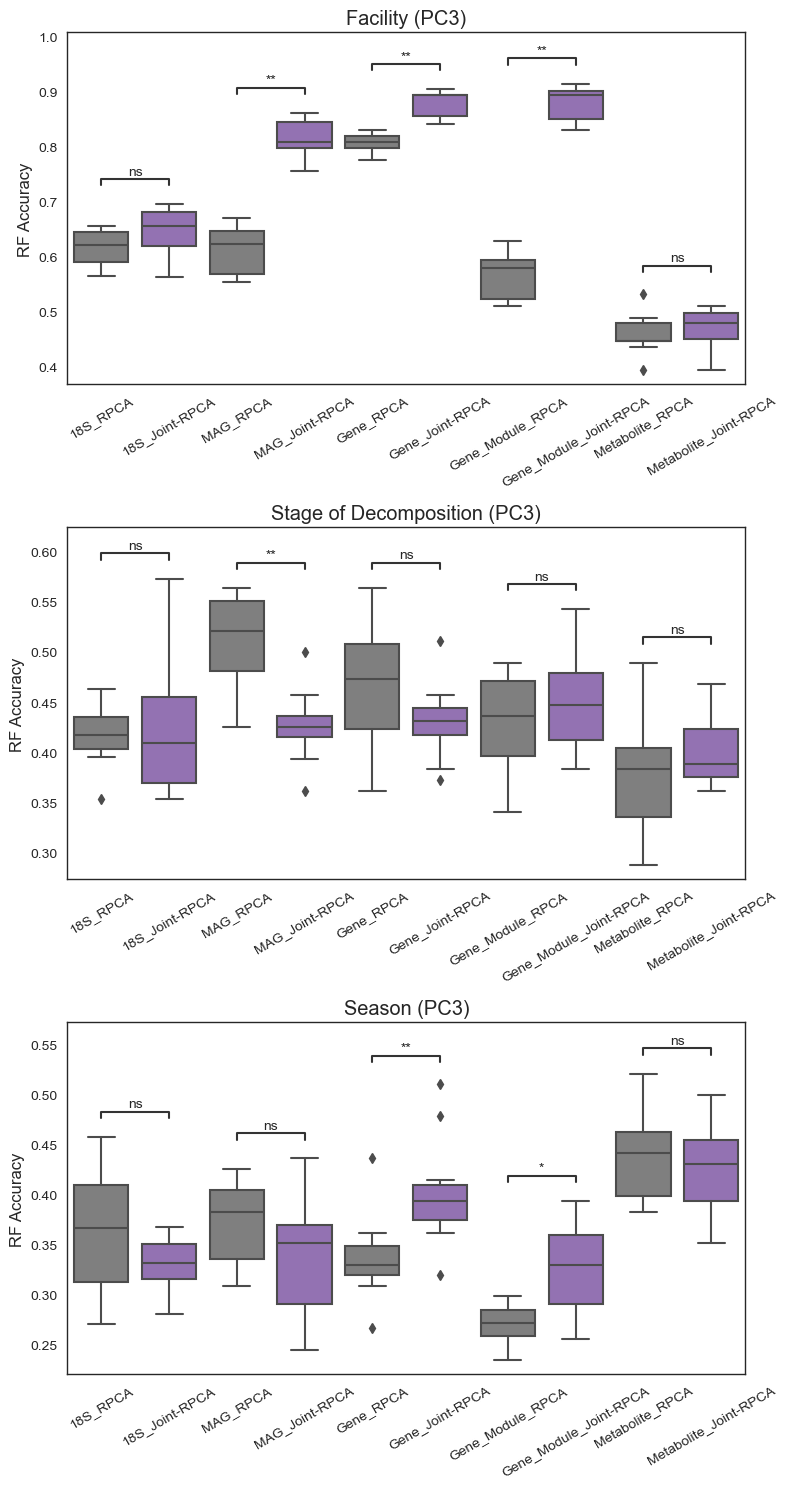

In [ ]:
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']

stat_pairs = [('18S_RPCA', '18S_Joint-RPCA'), 
              ('MAG_RPCA', 'MAG_Joint-RPCA'),
              ('Gene_RPCA', 'Gene_Joint-RPCA'), 
              ('Gene_Module_RPCA', 'Gene_Module_Joint-RPCA'),
              ('Metabolite_RPCA', 'Metabolite_Joint-RPCA')]

pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}

plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order_v1, 'palette':pair_palette}

fig, axn = plt.subplots(3, 1, figsize=(8, 15))

for ax_, data, title in zip(axn.flatten(), 
                           [acc_ratio_facility_opt, acc_ratio_stage_opt, acc_ratio_season_opt],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('RF Accuracy')
    ax_.set_title('{} ({})'.format(title, pc_to_use))

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Best RPCA PC vs. Best Joint-RPCA PC

In [16]:
pc_ratio = {}
ml_name = 'RF' #'KNN', 'RF'
for task in ['facility', 'stage', 'season']:
    acc_task = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy',
                                     'Report', 'Optimization', 'PC'])
    for pc in ['PC1','PC2','PC3','PC4']:
        #load results
        acc_ratio = pd.read_csv('../results/joint-rpca/{}/rf_acc_{}-ratio_{}_4PCs.csv'.format(ml_name, pc, task))
        #acc_ratio = pd.read_csv('../results/joint-rpca/{}/knn_acc_{}-ratio_{}_4PCs.tsv'.format(ml_name, pc, task),
        #                        sep='\t', index_col=0)
        #add PC column
        acc_ratio['PC'] = pc
        #save results
        acc_task = acc_task._append(acc_ratio, ignore_index=True)
    
    pc_ratio[task] = acc_task

In [17]:
best_pc_per_task = {}
pc_ratio_best = {}

for task in ['facility', 'stage', 'season']:
    print(task)
    #Find the median accuracy across folds for each modality and PC
    median_values = pc_ratio[task].groupby(['Omic', 'PC']).median(numeric_only=True)
    median_values = median_values.reset_index()

    #Find the PC with the maximum value for each Omic
    max_pc_per_omic = median_values.loc[median_values.groupby('Omic')['Accuracy'].idxmax()]

    #Store results in dictionary
    result_dict = max_pc_per_omic.set_index('Omic').apply(tuple, axis=1).to_dict()
    best_pc_per_task[task] = result_dict

    #store results in dataframe
    pc_ratio_plotting = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                              'Report', 'Optimization', 'PC'])

    for omic in result_dict.keys():
        pc_to_use = result_dict[omic][0]
        #filter out the other PCs
        mask = (pc_ratio[task]['Omic'] == omic) & (pc_ratio[task]['PC'] == pc_to_use)
        pc_ratio_task = pc_ratio[task][mask]
        #append to new df
        pc_ratio_plotting = pc_ratio_plotting._append(pc_ratio_task, ignore_index=True)
    pc_ratio_best[task] = pc_ratio_plotting
    
    display(max_pc_per_omic)
    print()

facility


,Omic,PC,Accuracy
2,18S_Joint-RPCA,PC3,0.578865
7,18S_RPCA,PC4,0.547646
10,Gene_Joint-RPCA,PC3,0.819149
14,Gene_Module_Joint-RPCA,PC3,0.861702
19,Gene_Module_RPCA,PC4,0.696809
22,Gene_RPCA,PC3,0.760638
27,MAG_Joint-RPCA,PC4,0.861702
29,MAG_RPCA,PC2,0.867021
34,Metabolite_Joint-RPCA,PC3,0.452128
36,Metabolite_RPCA,PC1,0.468085



stage


,Omic,PC,Accuracy
3,18S_Joint-RPCA,PC4,0.396972
5,18S_RPCA,PC2,0.416049
9,Gene_Joint-RPCA,PC2,0.436170
13,Gene_Module_Joint-RPCA,PC2,0.420213
17,Gene_Module_RPCA,PC2,0.452128
21,Gene_RPCA,PC2,0.484043
25,MAG_Joint-RPCA,PC2,0.473118
30,MAG_RPCA,PC3,0.441489
33,Metabolite_Joint-RPCA,PC2,0.388298
37,Metabolite_RPCA,PC2,0.409574



season


,Omic,PC,Accuracy
1,18S_Joint-RPCA,PC2,0.419530
4,18S_RPCA,PC1,0.418737
8,Gene_Joint-RPCA,PC1,0.425532
12,Gene_Module_Joint-RPCA,PC1,0.392473
19,Gene_Module_RPCA,PC4,0.393617
23,Gene_RPCA,PC4,0.404255
24,MAG_Joint-RPCA,PC1,0.420213
29,MAG_RPCA,PC2,0.414894
34,Metabolite_Joint-RPCA,PC3,0.367021
39,Metabolite_RPCA,PC4,0.377660


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:3.750e-01 Stat=1.800e+01
MAG_RPCA vs. MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:6.250e-01 Stat=2.200e+01
Gene_RPCA vs. Gene_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Metabolite_RPCA vs. Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:3.734e-01 Stat=1.500e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:4.316e-01 Stat=1.900e+01
MAG_RPCA vs. MAG_Joint-RPCA: Wil

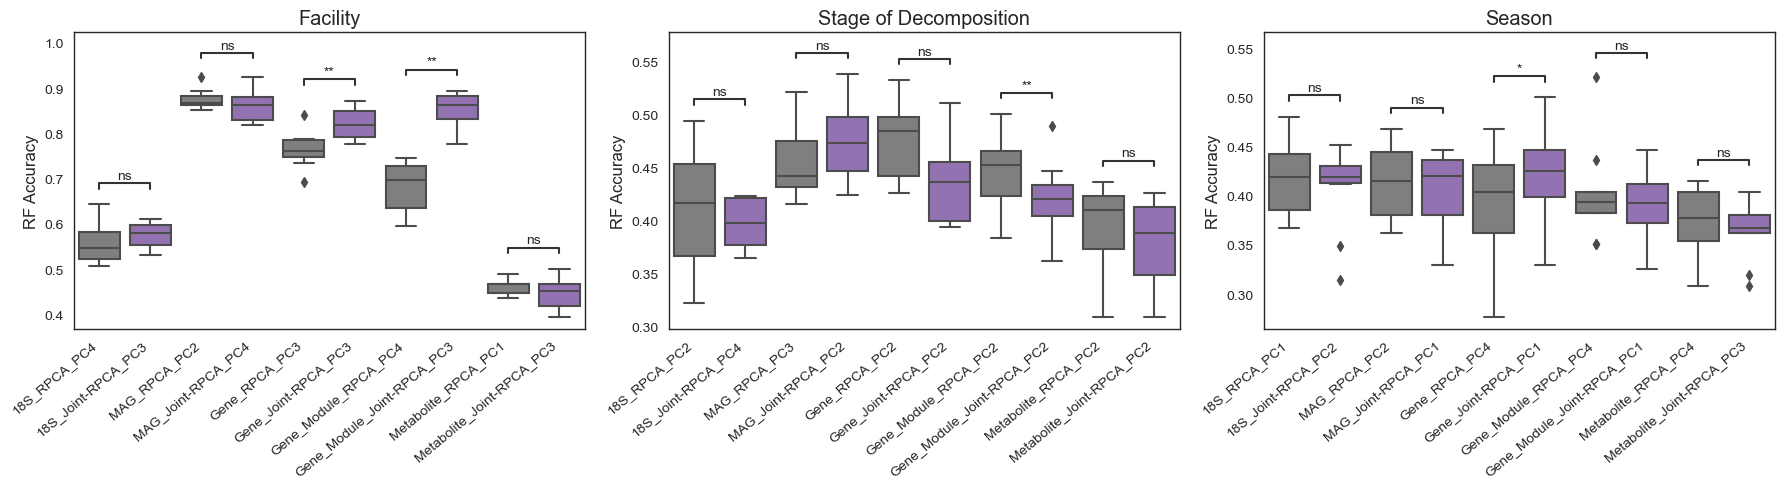

In [18]:
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']

stat_pairs = [('18S_RPCA', '18S_Joint-RPCA'), 
              ('MAG_RPCA', 'MAG_Joint-RPCA'),
              ('Gene_RPCA', 'Gene_Joint-RPCA'), 
              ('Gene_Module_RPCA', 'Gene_Module_Joint-RPCA'),
              ('Metabolite_RPCA', 'Metabolite_Joint-RPCA')]

pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}

plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order_v1, 'palette':pair_palette}

fig, axn = plt.subplots(1, 3, figsize=(18, 5))

for ax_, task, title in zip(axn.flatten(), pc_ratio.keys(),
                           ['Facility', 'Stage of Decomposition', 'Season']):
    #get best PC per omic
    best_pc = best_pc_per_task[task]
    rf_pc_ratio_plotting = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                                 'Report', 'Optimization', 'PC'])

    for omic in best_pc.keys():
        pc_to_use = best_pc[omic][0]
        #filter out the other PCs
        mask = (pc_ratio[task]['Omic'] == omic) & (pc_ratio[task]['PC'] == pc_to_use)
        rf_pc_ratio_task = pc_ratio[task][mask]
        #append to new df
        rf_pc_ratio_plotting = rf_pc_ratio_plotting._append(rf_pc_ratio_task, ignore_index=True)

    plotting_params['data'] = rf_pc_ratio_plotting
    sns.boxplot(ax=ax_, **plotting_params)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

    #update x tick labels
    mapping_dict = {}
    for omic, (pc, _) in best_pc_per_task[task].items():
        mapping_dict[omic] = '{}_{}'.format(omic, pc)

    current_labels = [tick.get_text() for tick in ax_.get_xticklabels()]
    updated_labels = [mapping_dict.get(label, label) for label in current_labels]

    ax_.set_xticklabels(updated_labels, rotation=40, ha='right')
    ax_.set_xlabel('')
    ax_.set_ylabel('{} Accuracy'.format(ml_name))
    ax_.set_title('{}'.format(title))

plt.tight_layout()
plt.show()

### Detailed F1-scores

In [28]:
#get best PC per omic
task = 'stage' #'season', 'facility'
#groups = ['fall', 'spring', 'summer', 'winter'] #for season
#groups = ['FIRS', 'STAFS', 'ARF'] #for facility
groups = ['active', 'advanced', 'initial', 'early'] #for stage

best_pc = best_pc_per_task[task]
rf_pc_ratio_plotting = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                             'Report', 'Optimization', 'PC'])
for omic in best_pc.keys():
    pc_to_use = best_pc[omic][0]
    #filter out the other PCs
    mask = (pc_ratio[task]['Omic'] == omic) & (pc_ratio[task]['PC'] == pc_to_use)
    rf_pc_ratio_task = pc_ratio[task][mask]
    #append to new df
    rf_pc_ratio_plotting = rf_pc_ratio_plotting._append(rf_pc_ratio_task, ignore_index=True)

display(rf_pc_ratio_plotting.head())

,Omic,Fold,Accuracy,Report,Optimization,PC
0,18S_Joint-RPCA,traintest_0,0.421687,precision recall f1-score ...,NaN,PC4
1,18S_Joint-RPCA,traintest_1,0.379310,precision recall f1-score ...,NaN,PC4
2,18S_Joint-RPCA,traintest_2,0.423077,precision recall f1-score ...,NaN,PC4
3,18S_Joint-RPCA,traintest_3,0.376471,precision recall f1-score ...,NaN,PC4
4,18S_Joint-RPCA,traintest_4,0.414634,precision recall f1-score ...,NaN,PC4


In [29]:
omic_f1_lst = []
for omic in rf_pc_ratio_plotting.Omic.unique():
    fold_f1_lst = []
    for fold in ['traintest_{}'.format(i) for i in range(10)]:
        #get report for each fold
        fold_report = rf_pc_ratio_plotting[(rf_pc_ratio_plotting.Omic == omic) & 
                                           (rf_pc_ratio_plotting.Fold == fold)].Report.values[0]
        #get each group's F1-score
        group_f1_lst = []
        for g, i in zip(groups, range(2, 6)):
            group_report = fold_report.split('\n')[i].split(' ')
            group_result = [x for x in group_report if len(x)>0][1:]
            group_f1 = [float(x) for x in group_result][2]
            group_f1_lst.append(group_f1)
        fold_f1_lst.extend(group_f1_lst)
    omic_f1_lst.extend(fold_f1_lst)

In [30]:
#create new dataframe with f1 results
omic_lst = [[omic] * 10 * len(groups) for omic in rf_pc_ratio_plotting.Omic.unique()]
omic_lst = np.concatenate(omic_lst)
fold = [['traintest_{}'.format(i)] * len(groups) for i in range(10)] * 10
fold = np.concatenate(fold)
group_lst = groups * 100

f1_df = pd.DataFrame({'Omic': omic_lst, 'Fold': fold, 
                      'Group': group_lst, 'F1-score': omic_f1_lst})
f1_df.head()

,Omic,Fold,Group,F1-score
0,18S_Joint-RPCA,traintest_0,active,0.43
1,18S_Joint-RPCA,traintest_0,advanced,0.56
2,18S_Joint-RPCA,traintest_0,initial,0.09
3,18S_Joint-RPCA,traintest_0,early,0.00
4,18S_Joint-RPCA,traintest_1,active,0.40


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

initial_Metabolite_RPCA vs. initial_Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:9.528e-01 Stat=2.200e+01
early_18S_RPCA vs. early_18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:2.359e-01 Stat=7.000e+00
early_Metabolite_RPCA vs. early_Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.776e-02 Stat=0.000e+00
advanced_Gene_Module_RPCA vs. advanced_Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:4.316e-01 Stat=1.850e+01
initial_MAG_RPCA vs. initial_MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:8.398e-02 Stat=1.050e+01
active_Gene_Module_RPCA vs. active_Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:7.216e-01 Stat=1.950e+01
active_Metabolite_RPCA vs. active_Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:6.536e-02 Sta

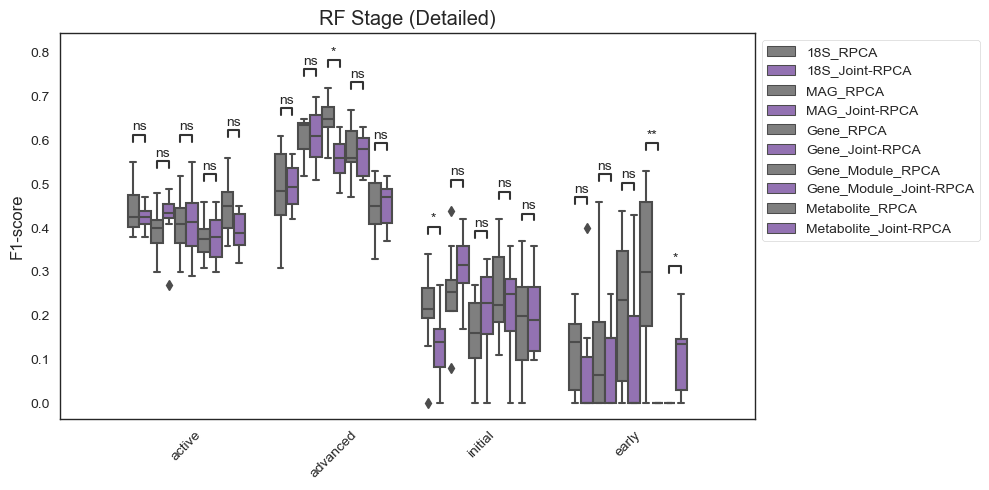

In [31]:
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
joint_rpca_types = ["18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                    "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"]
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 
            'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 
            'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']
stat_pairs = [[(g, rpca1), (g, rpca2)] for
               g in groups for rpca1, rpca2 in 
               zip(rpca_types, joint_rpca_types)]
pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}
plotting_params = {'x':'Group', 'y':'F1-score', 
                   'palette':pair_palette, 'hue_order':order_v1,
                   'data':f1_df, 'hue':'Omic'}

#seaborn boxplot of individual AUC_APRs without stat test
plt.figure(figsize=(10, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
ax_.set_xticklabels(ax_.get_xticklabels(), rotation=45)
ax_.set_xlabel('')
ax_.set_ylabel('F1-score')
ax_.set_title('{} {} (Detailed)'.format(ml_name, task.title()))
#plot legend outside of box
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Decomposer Network

In [32]:
pc_ratio = {}

for task in ['facility', 'stage', 'season']:
    acc_task = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy',
                                     'Report', 'Optimization', 'PC'])
    for pc in ['PC1','PC2','PC3','PC4']:
        #load results
        acc_ratio = pd.read_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_{}_4PCs.csv'.format(pc, task))
        #acc_ratio = pd.read_csv('../results/joint-rpca/KNN/knn_acc_{}-ratio_{}.tsv'.format(pc, task),
        #                        sep='\t', index_col=0)
        #add PC column
        acc_ratio['PC'] = pc
        #save results
        acc_task = acc_task._append(acc_ratio, ignore_index=True)
    
    pc_ratio[task] = acc_task

In [33]:
#create dict with best PC per omic, based on KW results
best_pc_per_task_kw = {'stage_minus_facility': {'18S_Joint-RPCA': 'PC2',
                                                '18S_RPCA': 'PC2',
                                                'Gene_Joint-RPCA': 'PC2',
                                                'Gene_RPCA': 'PC2',
                                                'Gene_Module_Joint-RPCA': 'PC2',
                                                'Gene_Module_RPCA': 'PC2',
                                                'MAG_Joint-RPCA': 'PC2',
                                                'MAG_RPCA': 'PC4',
                                                'Metabolite_Joint-RPCA': 'PC2',
                                                'Metabolite_RPCA': 'PC4'},
                        'stage_minus_season': {'18S_Joint-RPCA': 'PC2',
                                                '18S_RPCA': 'PC4',
                                                'Gene_Joint-RPCA': 'PC2',
                                                'Gene_RPCA': 'PC2',
                                                'Gene_Module_Joint-RPCA': 'PC2',
                                                'Gene_Module_RPCA': 'PC2',
                                                'MAG_Joint-RPCA': 'PC2',
                                                'MAG_RPCA': 'PC3',
                                                'Metabolite_Joint-RPCA': 'PC2',
                                                'Metabolite_RPCA': 'PC2'},
                        'stage_minus_both': {'18S_Joint-RPCA': 'PC2',
                                             '18S_RPCA': 'PC4',
                                             'Gene_Joint-RPCA': 'PC2',
                                             'Gene_RPCA': 'PC2',
                                             'Gene_Module_Joint-RPCA': 'PC2',
                                             'Gene_Module_RPCA': 'PC2',
                                             'MAG_Joint-RPCA': 'PC2',
                                             'MAG_RPCA': 'PC3',
                                             'Metabolite_Joint-RPCA': 'PC2',
                                             'Metabolite_RPCA': 'PC2'}}

In [39]:
acc_task = {}

for diff in best_pc_per_task_kw.keys():
    
    acc_omic = {}
    for omic in best_pc_per_task_kw[diff].keys():
        pc_to_use = best_pc_per_task_kw[diff][omic]

        #keep relevant PCs for each classification task
        mask = (pc_ratio['facility']['Omic'] == omic) & (pc_ratio['facility']['PC'] == pc_to_use)
        pc_ratio_facility = pc_ratio['facility'][mask]

        mask = (pc_ratio['stage']['Omic'] == omic) & (pc_ratio['stage']['PC'] == pc_to_use)
        pc_ratio_stage = pc_ratio['stage'][mask]

        mask = (pc_ratio['season']['Omic'] == omic) & (pc_ratio['season']['PC'] == pc_to_use)
        pc_ratio_season = pc_ratio['season'][mask]

        #calculate differences in accuracy for each fold
        acc_fold = []
        for fold in ['traintest_{}'.format(i) for i in range(10)]:

            stage_acc = pc_ratio_stage[pc_ratio_stage.Fold == fold].Accuracy.values[0]
            
            if diff == 'stage_minus_facility':
                facility_acc = pc_ratio_facility[pc_ratio_facility.Fold == fold].Accuracy.values[0]
                diff_ = stage_acc - facility_acc
                acc_fold.append(diff_)
            
            elif diff == 'stage_minus_season':
                season_acc = pc_ratio_season[pc_ratio_season.Fold == fold].Accuracy.values[0]
                diff_ = stage_acc - season_acc
                acc_fold.append(diff_)
            
            elif diff == 'stage_minus_both':
                facility_acc = pc_ratio_facility[pc_ratio_facility.Fold == fold].Accuracy.values[0]
                season_acc = pc_ratio_season[pc_ratio_season.Fold == fold].Accuracy.values[0]
                diff_ = stage_acc - (facility_acc + season_acc)
                #diff_ = stage_acc - (facility_acc + season_acc)/2
                acc_fold.append(diff_)

        acc_omic[omic] = acc_fold
    acc_task[diff] = acc_omic

In [40]:
diff_df = pd.DataFrame(columns=['Omic', 'Fold', 'Difference', 'Task'])
for task, omic_dict in acc_task.items():
    for omic, values in omic_dict.items():
        for fold, value in zip(['traintest_{}'.format(i) for i in range(10)], values):
            diff_df = diff_df._append({'Omic': omic, 'Fold': fold, 
                                       'Difference': value, 'Task': task}, ignore_index=True)
#sanity check  
display(diff_df)

,Omic,Fold,Difference,Task
0,18S_Joint-RPCA,traintest_0,-0.127907,stage_minus_facility
1,18S_Joint-RPCA,traintest_1,-0.193182,stage_minus_facility
2,18S_Joint-RPCA,traintest_2,-0.098765,stage_minus_facility
3,18S_Joint-RPCA,traintest_3,-0.070588,stage_minus_facility
4,18S_Joint-RPCA,traintest_4,-0.121951,stage_minus_facility
...,...,...,...,...
295,Metabolite_RPCA,traintest_5,-0.329787,stage_minus_both
296,Metabolite_RPCA,traintest_6,-0.297872,stage_minus_both
297,Metabolite_RPCA,traintest_7,-0.297872,stage_minus_both
298,Metabolite_RPCA,traintest_8,-0.393617,stage_minus_both


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

stage_minus_both_Metabolite_RPCA vs. stage_minus_both_Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:7.695e-01 Stat=2.350e+01
stage_minus_season_Gene_Module_RPCA vs. stage_minus_season_Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:2.734e-02 Stat=6.000e+00
stage_minus_both_MAG_RPCA vs. stage_minus_both_MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:9.766e-03 Stat=3.000e+00
stage_minus_facility_Gene_Module_RPCA vs. stage_minus_facility_Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.602e-01 Stat=1.250e+01
stage_minus_facility_Metabolite_RPCA vs. stage_minus_facility_Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:6.953e-01 Stat=2.350e+01
stage_minus_season_MAG_RPCA vs. stage_minus_season_MAG_Joint-RPCA: Wilcoxon test (paired samples),

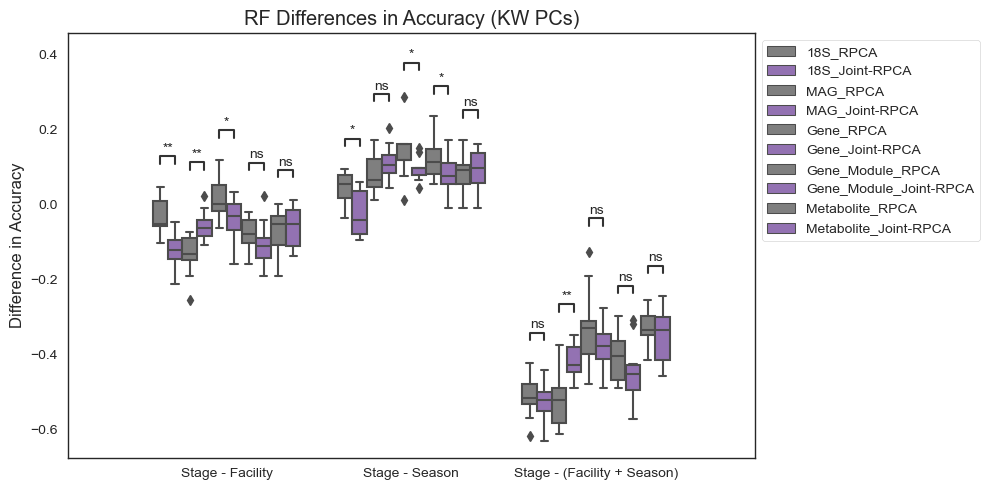

In [42]:
#barplot of differences
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
joint_rpca_types = ["18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                    "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"]
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 
            'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 
            'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']
pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}
groups = diff_df.Task.unique()
stat_pairs = [[(g, rpca1), (g, rpca2)] for
               g in groups for rpca1, rpca2 in 
               zip(rpca_types, joint_rpca_types)]
plotting_params = {'x':'Task', 'y':'Difference', 
                   'data':diff_df, 'palette':pair_palette,
                   'hue':'Omic', 'hue_order':order_v1,
                   'order': groups}

plt.figure(figsize=(10, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#update x labels
current_labels = [tick.get_text() for tick in ax_.get_xticklabels()]
updated_labels = ['Stage - Facility', 'Stage - Season', 
                  'Stage - (Facility + Season)']
ax_.set_xticklabels(updated_labels)
#x axis rotation
ax_.set_xlabel('')
ax_.set_ylabel('Difference in Accuracy')
ax_.set_title('RF Differences in Accuracy (KW PCs)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [43]:
##keep only stage_minus_both
diff_df_sub = diff_df[diff_df.Task == 'stage_minus_both'].copy()
#Create separate columns for Omic and Method
diff_df_sub['Omic_Only'] = [omic.split('_')[0] if 'Module' not in omic else '_'.join(omic.split('_')[0:2]) for omic in diff_df_sub.Omic]
diff_df_sub['Method'] = ["Joint-RPCA" if "Joint" in omic else "RPCA" for omic in diff_df_sub.Omic]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MAG_RPCA vs. MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:9.766e-03 Stat=3.000e+00
18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:6.953e-01 Stat=2.300e+01
Gene_RPCA vs. Gene_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.934e-01 Stat=1.400e+01
Gene_Module_RPCA vs. Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:8.398e-02 Stat=9.500e+00
Metabolite_RPCA vs. Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:7.695e-01 Stat=2.350e+01


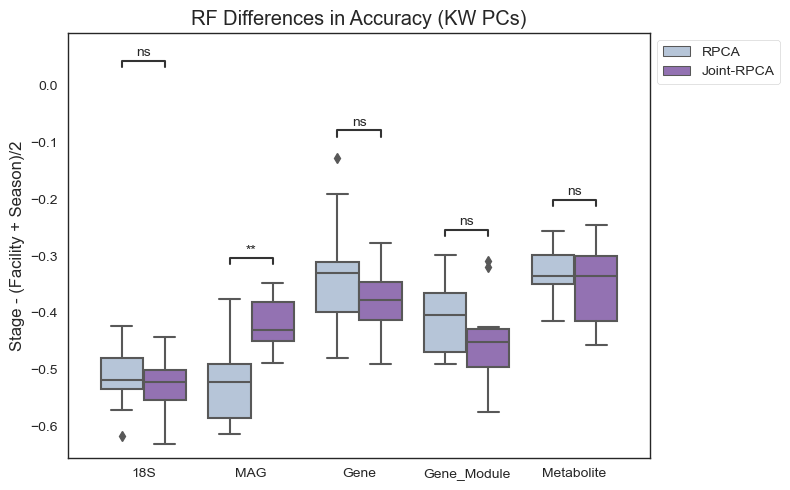

In [44]:
#barplot of differences
omic_types = diff_df_sub.Omic_Only.unique()
pair_palette = {'RPCA': 'lightsteelblue', 'Joint-RPCA': 'tab:purple'}
stat_pairs = [[(omic, "RPCA"), (omic, "Joint-RPCA")] for omic in omic_types]
plotting_params = {'x':'Omic_Only', 'y':'Difference', 
                   'data':diff_df_sub, 'palette':pair_palette,
                   'hue':'Method', 
                   'order': ['18S', 'MAG', 'Gene', 'Gene_Module', 'Metabolite'],
                   'hue_order':['RPCA', 'Joint-RPCA']}

plt.figure(figsize=(8, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
ax_.set_xlabel('')
#ax_.set_ylabel('Stage - (Facility + Season)')
ax_.set_ylabel('Stage - (Facility + Season)/2')
ax_.set_title('RF Differences in Accuracy (KW PCs)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [52]:
best_pc_stage_kw = 'PC2'
pc_to_use = best_pc_stage_kw

pc_ratio_stage = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy',
                                       'Report', 'Optimization', 'PC'])
#keep relevant PCs for each classification task
for omic in ['Metabolite_RPCA', 'Metabolite_Joint-RPCA']:
    mask = (pc_ratio['stage']['Omic'] == omic) & (pc_ratio['stage']['PC'] == pc_to_use)
    pc_ratio_sub = pc_ratio['stage'][mask]
    pc_ratio_stage = pc_ratio_stage._append(pc_ratio_sub, ignore_index=True)

In [53]:
groups = ['active', 'advanced', 'early', 'initial']
n_groups = len(groups)
omic_precision = {}
omic_recall = {}
omic_f1 = {}

for omic in pc_ratio_stage.Omic.unique():
    fold_precision_lst = []
    fold_recall_lst = []
    fold_f1_lst = []
    for fold in ['traintest_{}'.format(i) for i in range(10)]:
        #get report for each fold
        fold_report = pc_ratio_stage[(pc_ratio_stage.Omic == omic) & 
                                     (pc_ratio_stage.Fold == fold)].Report.values[0]
        #store precision and recall scores for all groups
        group_precision_lst = []
        group_recall_lst = []
        group_f1_lst = []
        #we start at 2 to skip the title and a line skip
        for i in range(2, n_groups+2):
            #get group-specific results
            group_report = fold_report.split('\n')[i].split(' ')
            #keep only non-empty strings
            group_result = [x for x in group_report if len(x)>0][1:]
            group_precision = [float(x) for x in group_result][0]
            group_recall = [float(x) for x in group_result][1]
            group_f1 = [float(x) for x in group_result][2]
            #append to fold list
            group_precision_lst.append(group_precision)
            group_recall_lst.append(group_recall)
            group_f1_lst.append(group_f1)
        
        #calculate fold average
        fold_precision_lst.append(np.mean(group_precision_lst))
        fold_recall_lst.append(np.mean(group_recall_lst))
        fold_f1_lst.append(np.mean(group_f1_lst))

    #save results at the omic level
    omic_precision[omic] = fold_precision_lst
    omic_recall[omic] = fold_recall_lst
    omic_f1[omic] = group_f1_lst

In [54]:
#create new dataframe avg precision and recall results
omic_lst = [[omic] * 10 for omic in pc_ratio_stage.Omic.unique()]
omic_lst = np.concatenate(omic_lst)
fold = [['traintest_{}'.format(i)] for i in range(10)] * 2
fold = np.concatenate(fold)
precisions = np.concatenate([omic_precision[omic] for omic in pc_ratio_stage.Omic.unique()])
recalls = np.concatenate([omic_recall[omic] for omic in pc_ratio_stage.Omic.unique()])
f1s = np.concatenate([omic_f1[omic] for omic in pc_ratio_stage.Omic.unique()])

precision_recall_df = pd.DataFrame({'Omic': omic_lst, 'Fold': fold,
                                    'Avg_Precision': precisions,
                                    'Avg_Recall': recalls})

<Axes: xlabel='Omic', ylabel='value'>

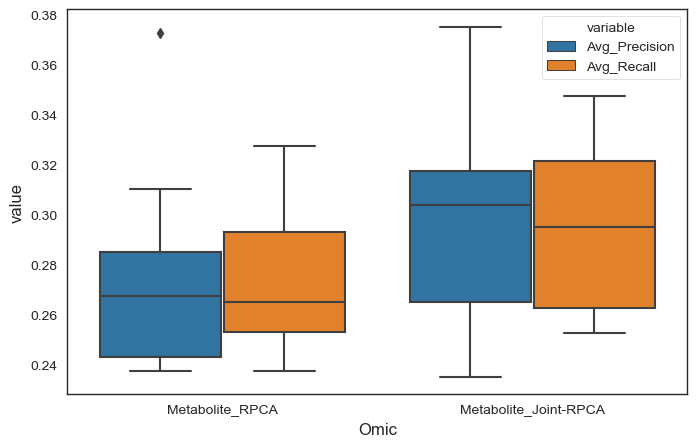

In [55]:
#boxplot of precision and recall
plt.figure(figsize=(8, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, x='Omic', y='value', hue='variable',
            data=pd.melt(precision_recall_df, ['Omic', 'Fold']),
            palette='tab10')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


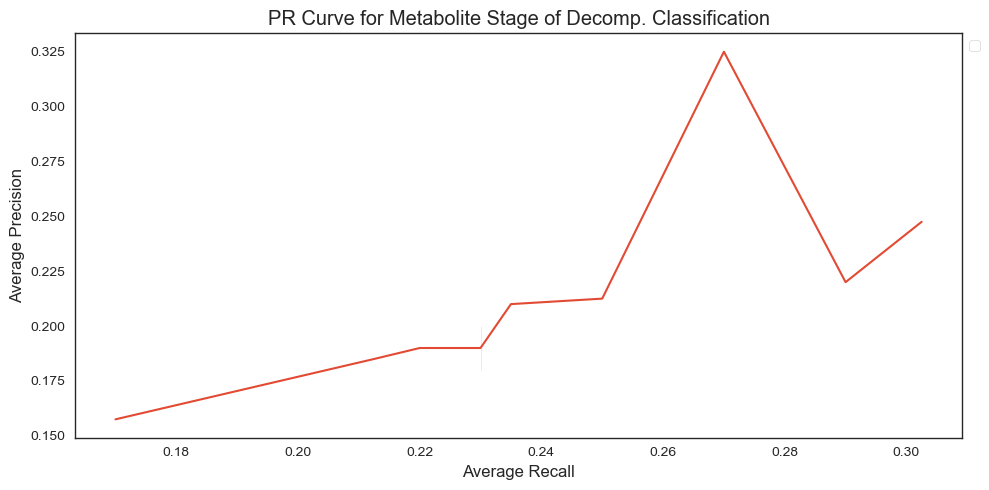

In [ ]:
#plot precision and recall curve for each omic on same plot
plt.figure(figsize=(10, 5))
ax_ = plt.gca()
sns.lineplot(data=precision_recall_df[precision_recall_df.Omic == 'Metabolite_RPCA'], 
             x='Avg_Recall', y='Avg_Precision')
ax_.set_xlabel('Average Recall')
ax_.set_ylabel('Average Precision')
ax_.set_title('PR Curve for Metabolite Stage of Decomp. Classification')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


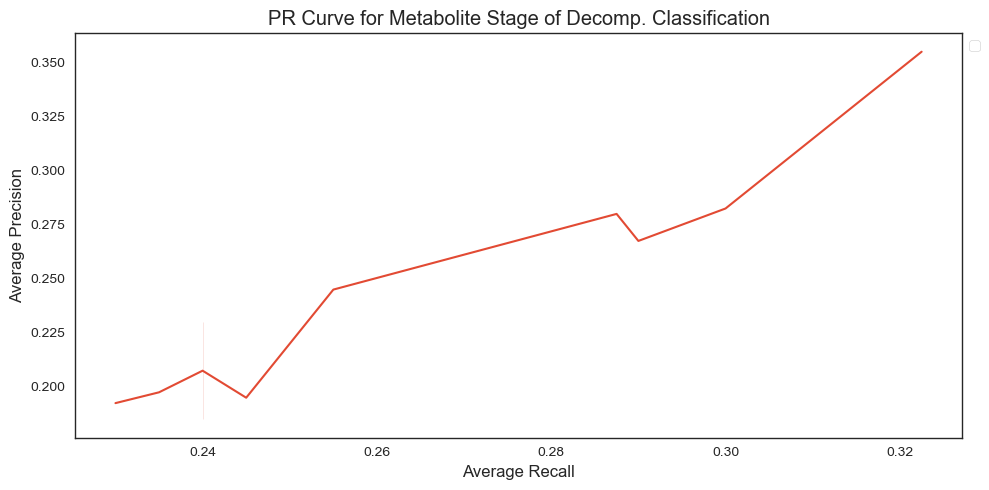

In [ ]:
#plot precision and recall curve for each omic on same plot
plt.figure(figsize=(10, 5))
ax_ = plt.gca()
sns.lineplot(data=precision_recall_df[precision_recall_df.Omic == 'Metabolite_Joint-RPCA'], 
             x='Avg_Recall', y='Avg_Precision')
ax_.set_xlabel('Average Recall')
ax_.set_ylabel('Average Precision')
ax_.set_title('PR Curve for Metabolite Stage of Decomp. Classification')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()